# Matchups of in situ data with satellite data

**Tutorial Leads:** Anna Windle (NASA, SSAI), James Allen (NASA, MSU)

## Summary

In this example we will conduct matchups of in situ AERONET-OC Rrs data with PACE OCI Rrs data. The Aerosol Robotic Network (AERONET) was developed to sustain atmospheric studies at various scales with measurements from worldwide distributed autonomous sun-photometers. This has been extended to support marine applications, called AERONET – Ocean Color [(AERONET-OC)](https://aeronet.gsfc.nasa.gov/new_web/ocean_levels_versions.html), and provides the additional capability of measuring the radiance emerging from the sea (i.e., water-leaving radiance) with modified sun-photometers installed on offshore platforms like lighthouses, oceanographic and oil towers. AERONET-OC is instrumental in satellite ocean color validation activities. 

In this tutorial, we will be collecting Rrs data from the  [Casablanca Platform](https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_seaprism_v3?site=Casablanca_Platform&nachal=2&level=3&place_code=10) AERONET-OC site located at 40.7N, 1.4W in the western Mediterranean Sea which is typically characterized as oligotrophic/mesotrophic (ocean color signals tend to strongly covary with chlorophyll a).

We will be collecting PACE OCI Rrs data in a 5x5 pixel window around the AERONET-OC site to compare to the AERONET-OC Rrs data. 

## Learning Objectives

At the end of this notebook you will know:

* How to access Rrs data from a specific AERONET-OC site and time
* How to access PACE OCI Rrs data from a specific location and time
* How to match in situ and satellite data
* How to apply statistics and plot matchup data

## Contents

1. [Setup](#1.-Setup)
2. [Process AERONET-OC data](#2.-Process-AERONET-OC-data)
3. [Process PACE OCI data](#3.-Process-PACE-OCI-data)
4. [Apply matchup code](#4.-Apply-matchup-code)
5. [Make plots](#5.-Make-plots)

## 1. Setup

We begin by loading a set of utility functions that work behind the scenes to do the majority of the work for us. 
Collapse this for now and just run the cell, but feel free to dig into it and see how things work!

<div class="alert alert-block alert-warning"> 
    
Note that the `get_f0` function requires the thuillier2003_f0.nc file. For the Hackweek, this is being pulled from the shared-public directory. For others trying to run the notebook, the .nc file can be found [here](https://oceancolor.gsfc.nasa.gov/docs/rsr/f0.txt). 

</div>

In [1]:
"""
Helper functions for PACE Hackweek Validation Tutorial.

Authors:
    James Allen and Anna Windle
"""
import datetime
from pathlib import Path
import re

import earthaccess
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import pvlib.solarposition as sunpos
from scipy import stats, odr
import seaborn as sns
import xarray as xr

# AERONET-OC Download Constants
# Valid AERONET-OC site list
AERONET_SITES = [
    'AAOT', 'Abu_Al_Bukhoosh', 'ARIAKE_TOWER', 'Bahia_Blanca', 'Banana_River',
    'Blyth_NOAH', 'Casablanca_Platform', 'Chesapeake_Bay', 'COVE_SEAPRISM',
    'Galata_Platform', 'Gloria', 'GOT_Seaprism', 'Grizzly_Bay',
    'Gustav_Dalen_Tower', 'Helsinki_Lighthouse', 'Ieodo_Station',
    'Irbe_Lighthouse', 'Kemigawa_Offshore', 'Lake_Erie', 'Lake_Okeechobee',
    'Lake_Okeechobee_N', 'LISCO', 'Lucinda', 'MVCO', 'Palgrunden',
    'PLOCAN_Tower', 'RdP-EsNM', 'Sacramento_River', 'San_Marco_Platform',
    'Section-7_Platform', 'Socheongcho', 'South_Greenbay', 'Thornton_C-power',
    'USC_SEAPRISM', 'Venise', 'WaveCIS_Site_CSI_6', 'Zeebrugge-MOW1'
    ]

# Get subset of AERONET columns to make it a bit more manageable (also rename)
AOC_KEEP_COLS = ["AERONET_Site", "aoc_datetime", "Site_Latitude(Degrees)",
                 "Site_Longitude(Degrees)", "Solar_Zenith_Angle[400nm]"]
COLUMN_RENAME = {
    "Site_Latitude(Degrees)": "aoc_latitude",
    "Site_Longitude(Degrees)": "aoc_longitude",
    "AERONET_Site": "aoc_site",
    "Solar_Zenith_Angle[400nm]": "aoc_solar_zenith"
    }

# Bland-Altman/Scatterplot Constants
# Plot colors, font sizes
COLOR_PALETTE = sns.color_palette("colorblind")
COLOR_SCATTER = COLOR_PALETTE[0]
COLOR_LINE = "black"  # Was "black"
COLOR_LOA = COLOR_PALETTE[2]  # Was "green"
COLOR_FITLINE = COLOR_PALETTE[1]  # Was "magenta"
SIZE_TITLE = 24
SIZE_AXLABEL = 20
SIZE_TEXTLABEL = 14
SHOW_LEGEND = False

# Update some defaults
plt.rcParams.update({"figure.dpi": 300})
sns.set_style("ticks", rc={"figure.dpi": 300})
sns.set_context("notebook", font_scale=1.45)

# Satellite Matchup Constants
# Short names for earthaccess lookup
SAT_LOOKUP = {
    "PACE": "PACE_OCI_L2_AOP_NRT",
    "AQUA": "MODISA_L2_OC",
    "TERRA": "MODIST_L2_OC",
    "NOAA-20": "VIIRSJ1_L2_OC",
    "NOAA-21": "VIIRSJ2_L2_OC",
    "SUOMI-NPP": "VIIRSN_L2_OC"
    }

# List l2 flags, then build them into a dict
l2_flags_list = [
    "ATMFAIL", "LAND", "PRODWARN", "HIGLINT", "HILT", "HISATZEN", "COASTZ",
    "SPARE", "STRAYLIGHT", "CLDICE", "COCCOLITH", "TURBIDW", "HISOLZEN",
    "SPARE", "LOWLW", "CHLFAIL", "NAVWARN", "ABSAER", "SPARE", "MAXAERITER",
    "MODGLINT", "CHLWARN", "ATMWARN", "SPARE", "SEAICE", "NAVFAIL", "FILTER",
    "SPARE", "BOWTIEDEL", "HIPOL", "PRODFAIL", "SPARE"]
L2_FLAGS = {flag: 1 << idx for idx, flag in enumerate(l2_flags_list)}

# Bailey and Werdell 2006 exclusion criteria
EXCLUSION_FLAGS = ["LAND", "HIGLINT", "HILT", "STRAYLIGHT", "CLDICE",
                   "ATMFAIL", "LOWLW", "FILTER", "NAVFAIL", "NAVWARN"]

# --------------------------------------------------------------------------- #
#                              General Utilities                              #
# --------------------------------------------------------------------------- #


def get_f0(wavelengths=None, obs_time=None, window_size=10, f0_file=None):
    """
    Load the Thuillier2003 netCDF file and return F0.

    Defaults to returning the full table. Input obs_time to correct for the
    Earth-Sun distance.

    Parameters
    ----------
    wavelengths : array-like, optional
        Wavelengths at which to compute the average irradiance.
        If None, returns the full wavelength and irradiance table.
    obs_time : datetime.datetime or pd.Series, optional
        Observation time(s) used to correct for the Earth-Sun distance.
        If None, return the mean F0 values.
    window_size : int, optional
        Bandpass filter size for mean filtering to selected wavelengths, in nm.
    f0_file : str or pathlib.Path
        Path to the f0 netCDF file of the lookup table.

    Returns
    -------
    tuple of np.ndarray
        A tuple containing:
        - f0_spectra : np.ndarray
            The solar irradiance values.
        - f0_wave : np.ndarray
            The corresponding wavelengths.
    """
    if f0_file is None:
        f0_file = Path("/home/jovyan/shared/pace-hackweek-2024/thuillier2003_f0.nc")
    f0_file = Path(f0_file)

    if not f0_file.is_file():
        raise FileNotFoundError(f"File not found: {f0_file}")

    ds_f0 = xr.load_dataset(f0_file)
    wl = ds_f0["wavelength"].values
    f0 = ds_f0["irradiance"].values

    if wavelengths is not None:
        f0_wave = np.array(wavelengths)
        f0_spectra = bandpass_avg(f0, wl, window_size, f0_wave)
    else:
        f0_wave = wl
        f0_spectra = f0

    if obs_time is not None:
        # Calculate Earth-Sun distance
        es_distance = sunpos.nrel_earthsun_distance(obs_time).to_numpy()

        # Deal with multiple input times
        if len(pd.Series(obs_time)) > 1:
            f0_spectra = f0_spectra[None, :] / es_distance[:, None]**2
        else:
            f0_spectra /= es_distance**2

    return f0_spectra, f0_wave


def bandpass_avg(data, input_wavelengths, window_size=10,
                 target_wavelengths=None):
    """
    Apply a band-pass filter to the data.

    Parameters
    ----------
    data : np.ndarray
        1D or 2D array containing the spectral data (samples x wavelengths).
        If 1D, it's assumed to be a single sample.
    input_wavelengths : np.ndarray
        1D array of wavelength values corresponding to the columns of data.
    window_size : int, optional
        Size of the window to use for averaging. Default is 10 nm.
    target_wavelengths : np.ndarray, optional
        1D array of target wavelengths for filtered values.
        If None, the input wavelengths are used.

    Returns
    -------
    np.ndarray
        1D or 2D array containing the band-pass filtered data.
    """
    data = np.atleast_2d(data)
    half_window = window_size / 2
    num_samples, num_input_wavelengths = data.shape
    if target_wavelengths is None:
        target_wavelengths = input_wavelengths

    filtered_data = np.empty((num_samples, len(target_wavelengths)))

    for idx, target_wl in enumerate(target_wavelengths):
        start = target_wl - half_window
        end = target_wl + half_window
        cols_in_range = np.where((input_wavelengths >= start)
                                 & (input_wavelengths <= end))[0]
        filtered_data[:, idx] = np.nanmean(data[:, cols_in_range], axis=1)

    return filtered_data if num_samples > 1 else filtered_data.flatten()


def get_column_prods(df, type_prefix):
    """Process a dataframe to create a dictionary of data products.

    Parameters
    ----------
    df : pandas DataFrame
        Extracted dataframes from read_extract_file
    type_prefix : str
        Prefix to identify the product columns, e.g. "aoc"

    Returns
    -------
    data_dict
        dictionary mapping data product with their wavelengths and columns.
    """
    data_dict = {}
    pattern = rf'{type_prefix}_(\w+?)(\d*\.?\d+)?$'

    for col in df.columns:
        match = re.match(pattern, col)
        if match:
            product = match.group(1)
            wavelength = match.group(2) if match.group(2) else None
            if product not in data_dict:
                data_dict[product] = {'wavelengths': [], 'columns': []}
            data_dict[product]['columns'].append(col)
            if wavelength:
                if '.' in wavelength:
                    data_dict[product]['wavelengths'].append(float(wavelength))
                else:
                    data_dict[product]['wavelengths'].append(int(wavelength))
    return data_dict

# --------------------------------------------------------------------------- #
#                            AERONET_OC Utilities                             #
# --------------------------------------------------------------------------- #


def construct_url(aoc_site, data_level, start_date, end_date):
    """
    Craft the AERONET-OC data URL.

    Parameters
    ----------
    aoc_site : str, optional
        Specific AERONET-OC site (else AAOT by default)
    start_date : datetime object, optional
        Beginning of Aeronet data to run. Defaults to 1 Mar 2024.
    end_date : datetime object, optional
        End of Aeronet data to run. Defaults to today.
    data_level : int, {10, 15, 20}
        data quality; 20 (default, highest quality), 15, or 10.

    Returns
    -------
    str
        url to API pull
    """
    # Validate inputs
    if aoc_site not in AERONET_SITES:
        raise ValueError(f"{aoc_site} is not an AERONET site. Available "
                         f"sites are: {', '.join(AERONET_SITES)}")

    url = ("https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?"
           f"AVG=10&LWN{data_level}=1&year={start_date.year}"
           f"&month={start_date.month}&day={start_date.day}"
           f"&if_no_html=1&year2={end_date.year}&month2={end_date.month}"
           f"&day2={end_date.day}&site={aoc_site}")

    return url


def get_data_dict(df, search_str=None):
    """Process a dataframe to create a dict and ndarray of products and waves.

    Parameters
    ----------
    df : pandas DataFrame
        Extracted dataframes from read_extract_file

    Returns
    -------
    wavelengths
        numpy array of wavelengths of the data
    column_map
        dict of the dataframe columns associated with each wavelength
    """
    if search_str is None:
        search_str = "Lwn_IOP"
    wavelengths = []
    column_map = {}
    pattern = re.compile(rf'{search_str}\[(\d+)nm\]')

    for col in df.columns:
        match = pattern.search(col)
        if match:
            wavelength = int(match.group(1))
            wavelengths.append(wavelength)
            column_map[wavelength] = col
    return np.array(wavelengths), column_map


def process_aeronet(aoc_site="AAOT", start_date="2024-03-01", end_date=None,
                    data_level=15):
    """
    Download and process AERONET-OC data for matchups.

    Parameters
    ----------
    aoc_site : str, optional
        Specific AERONET-OC site (else AAOT by default)
    start_date : datetime or str, optional
        Beginning of Aeronet data to run. Defaults to "2024-03-01"
    end_date : datetime or str, optional
        End of Aeronet data to run. Defaults to today.
    data_level : int, {10, 15, 20}
        data quality; 20 (highest, but fewest), 15 (autochecked), or 10.

    Returns
    -------
    pandas DataFrame object
        Dataframe of downloaded AERONET-OC data
    """
    # Set up processing
    if end_date is None:
        end_date = datetime.now()
    start_date = pd.to_datetime(start_date, errors='raise')
    end_date = pd.to_datetime(end_date, errors='raise')

    # Make url
    url_aoc = construct_url(aoc_site, data_level, start_date, end_date)

    # Download data (skip the 5 header rows)
    try:
        df_aoc_full = pd.read_csv(url_aoc, delimiter=",", na_values=-999,
                                  skiprows=5)
    except Exception as e:
        raise Exception(f"Could not download data. Try another station, reduce"
                        f" the data_level, or expand the times. (Error: {e})")

    # Drop empty columns
    df_aoc_full.dropna(axis=1, how='all', inplace=True)

    # Parse datetimes
    df_aoc_full['aoc_datetime'] = pd.to_datetime(
        df_aoc_full["Date(dd-mm-yyyy)"] + ' ' + df_aoc_full["Time(hh:mm:ss)"],
        format="%d:%m:%Y %H:%M:%S"
        ).dt.tz_localize("UTC")

    # Get subset of Lwn_f/Q columns (ignore the count columns)
    # Alternatively, could pull Lwn_IOP for L11 BRDF
    subset_lwn = [col for col in df_aoc_full.columns
                  if "Lwn_f/Q" in col and "N[Lwn_f/Q" not in col]
    lwn_iop = df_aoc_full[subset_lwn].values

    # Now get array of wavelengths from columns
    wavelengths, _ = get_data_dict(df_aoc_full[subset_lwn], "Lwn_f/Q")

    # Lwn need to be normalized by F0, the mean solar irradiance at top of atm
    # Note: Lwn_IOP already accounts for the Earth-Sun Distance, BRDF, and
    # atmosphere transmittance
    f0_spectra, _ = get_f0(wavelengths)

    # Normalize to get Rrs
    rrs = lwn_iop / f0_spectra[None, :]

    # Generate new column names and make the rrs dataframe
    aoc_rrs_cols = [f"aoc_rrs{wavelength}" for wavelength in wavelengths]
    df_rrs = pd.DataFrame(rrs, columns=aoc_rrs_cols)

    # Now combine with the subset of the full dataframe
    df_aoc = pd.concat([df_aoc_full[AOC_KEEP_COLS], df_rrs], axis=1)

    # Do some final cleanup
    df_aoc.rename(columns=COLUMN_RENAME, inplace=True)

    return df_aoc


# --------------------------------------------------------------------------- #
#                             Satellite Utilities                             #
# --------------------------------------------------------------------------- #


def parse_quality_flags(flag_value):
    """
    Parse bitwise flag into a list of flag names.

    Parameters
    ----------
    flag_value : int
        The integer representing the combined bitwise quality flags.

    Returns
    -------
    list of str
        List of flag names that are set in the flag_value.
    """
    return [flag_name for flag_name, value in L2_FLAGS.items()
            if (flag_value & value) != 0]


def get_fivebyfive(file, latitude, longitude, rrs_wavelengths):
    """
    Get stats on a 5x5 box around station coordinates of a satellite granule.

    Parameters
    ----------
    file : earthaccess granule object
        Satellite granule from earthaccess.
    latitude : float
        In decimal degrees for Aeronet-OC site for matchups
    longitude : float
        In decimal degrees (negative West) for Aeronet-OC site for matchups
    rrs_wavelengths ; numpy array
        Rrs wavelengths (from wavelength_3d for OCI)

    Returns
    -------
    None.
    """
    with xr.open_dataset(file, group="navigation_data") as ds_nav:
        sat_lat = ds_nav['latitude'].values
        sat_lon = ds_nav['longitude'].values

    # Calculate the Euclidean distance for 2D lat/lon arrays
    distances = np.sqrt((sat_lat - latitude)**2 + (sat_lon - longitude)**2)

    # Find the index of the minimum distance
    # Dimensions are (lines, pixels)
    min_dist_idx = np.unravel_index(np.argmin(distances), distances.shape)
    center_line, center_pixel = min_dist_idx

    # Get indices for a 5x5 box around the center pixel
    line_start = max(center_line - 2, 0)
    line_end = min(center_line + 2 + 1, sat_lat.shape[0])
    pixel_start = max(center_pixel - 2, 0)
    pixel_end = min(center_pixel + 2 + 1, sat_lat.shape[1])

    # Extract the data
    with xr.open_dataset(file, group="geophysical_data") as ds_data:
        rrs_data = ds_data['Rrs'].isel(
            number_of_lines=slice(line_start, line_end),
            pixels_per_line=slice(pixel_start, pixel_end)
            ).values
        flags_data = ds_data['l2_flags'].isel(
            number_of_lines=slice(line_start, line_end),
            pixels_per_line=slice(pixel_start, pixel_end)
            ).values

    # Calculate the bitwise OR of all flags in EXCLUSION_FLAGS to get a mask
    exclude_mask = sum(L2_FLAGS[flag] for flag in EXCLUSION_FLAGS)

    # Create a boolean mask
    # True means the flag value does not contain any of the EXCLUSION_FLAGS
    valid_mask = np.bitwise_and(flags_data, exclude_mask) == 0

    # Get stats and averages
    if valid_mask.any():
        rrs_valid = rrs_data[valid_mask]
        rrs_std_initial = np.std(rrs_valid, axis=0)
        rrs_mean_initial = np.mean(rrs_valid, axis=0)

        # Exclude spectra > 1.5 stdevs away
        std_mask = np.all(
            np.abs(rrs_valid - rrs_mean_initial) <= 1.5 * rrs_std_initial,
            axis=1)
        rrs_std = np.std(rrs_valid[std_mask], axis=0)
        rrs_mean = np.mean(rrs_valid[std_mask], axis=0).flatten()

        # Matchup criteria uses cv as median of 405-570nm
        rrs_cv = rrs_std / rrs_mean
        rrs_cv_median = np.median(rrs_cv[(rrs_wavelengths >= 405)
                                         & (rrs_wavelengths <= 570)])
    else:
        rrs_cv_median = np.nan
        rrs_mean = np.nan * np.empty_like(rrs_wavelengths)

    # Put in dictionary of the row
    row = {
        "oci_datetime": pd.to_datetime(file.granule["umm"]["TemporalExtent"]
                                       ["RangeDateTime"]["BeginningDateTime"]),
        "oci_cv": rrs_cv_median,
        "oci_latitude": sat_lat[center_line, center_pixel],
        "oci_longitude": sat_lon[center_line, center_pixel],
        "oci_pixel_valid": np.sum(valid_mask)
    }

    # Add mean spectra to the row dictionary
    for wavelength, mean_value in zip(rrs_wavelengths, rrs_mean):
        key = f'oci_rrs{int(wavelength)}'
        row[key] = mean_value

    return row


def process_satellite(start_date, end_date, latitude, longitude, sat="PACE",
                      selected_dates=None):
    """
    Download and process satellite data for matchups.

    Caution: If the date or coordinates aren't formatted correctly, it might
    pull a huge granule list and take forever to run. If it takes more than 45
    seconds to print the number of granules, just kill the process.

    Uses the earthaccess package. Defaults to the PACE OCI L2 IOP datasets,
    but other satellites can be used if they have a corresponding short_name
    in the SAT_LOOKUP dictionary.

    Workflow:
        1. Get list of matchup granules
        2. Loop through each file and:
            2a. Find closest pixel to station, extract 5x5 pixel box
            2b. Exclude pixels based on l2_flags
            2c. Filtered mean to get single spectra
            2d. Compute statistics and save data row
        3. Organize output pandas dataframe

    Parameters
    ----------
    start_date : datetime or str
        Beginning of Aeronet data to run.
    end_date : datetime or str, optional
        End of Aeronet data to run.
    latitude : float
        In decimal degrees for Aeronet-OC site for matchups
    longitude : float
        In decimal degrees (negative West) for Aeronet-OC site for matchups
    sat : str
        Name of satellite to search. Must be in SAT_LOOKUP dict constant.
    selected_dates : list of str, optional
        If given, only pull granules if the dates are in this list

    Returns
    -------
    pandas DataFrame object
        Flattened table of all satellite granule matchups.

    """
    # Look up short name from constants
    if sat not in SAT_LOOKUP.keys():
        raise ValueError(f"{sat} is not in the lookup dictionary. Available "
                         f"sats are: {', '.join(SAT_LOOKUP)}")
    short_name = SAT_LOOKUP[sat]

    # Format search parameters
    time_bounds = (f"{start_date}T00:00:00", f"{end_date}T23:59:59")

    # Run Earthaccess data search
    results = earthaccess.search_data(point=(longitude, latitude),
                                      temporal=time_bounds,
                                      short_name=short_name)
    if selected_dates is not None:
        filtered_results = [
            result for result in results
            if result["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"][:10]
            in selected_dates
            ]
        print(f"Filtered to {len(filtered_results)} Granules.")
        files = earthaccess.open(filtered_results)
    else:
        files = earthaccess.open(results)

    # Pull out Rrs wavelengths for easier processing
    with xr.open_dataset(files[0], group="sensor_band_parameters") as ds_bands:
        rrs_wavelengths = ds_bands["wavelength_3d"].values

    # Loop through files and process
    sat_rows = []
    for idx, file in enumerate(files):
        granule_date = pd.to_datetime(file.granule["umm"]["TemporalExtent"]
                                      ["RangeDateTime"]["BeginningDateTime"])
        print(f"Running Granule: {granule_date}")
        row = get_fivebyfive(file, latitude, longitude, rrs_wavelengths)
        sat_rows.append(row)

    return pd.DataFrame(sat_rows)

# --------------------------------------------------------------------------- #
#                              Matchup Utilities                              #
# --------------------------------------------------------------------------- #


def match_data(df_sat, df_aoc, cv_max=0.15, senz_max=60.0,
               min_percent_valid=55.0, max_time_diff=180, std_max=1.5):
    """Create matchup dataframe based on selection criteria.

    Parameters
    ----------
    df_sat : pandas dataframe
        Satellite data from flat validation file.
    df_aoc : pandas dataframe
        Field data from flat validation file.
    cv_max : float, default 0.15
        Maximum coefficient of variation (stdev/mean) for sat data.
    senz_max : float, default 60.0
        Maximum sensor zenith for sat data.
    min_percent_valid : float, default 55.0
        Minimum percentage of valid satellite pixels.
    max_time_diff : int, default 180
        Maximum time difference (minutes) between sat and field matchup.
    std_max : float, default 1.5
        If multiple valid field matchups, select within std_max stdevs of mean.

    Returns
    -------
    pandas dataframe of matchups for product
    """
    # Setup
    time_window = pd.Timedelta(minutes=max_time_diff)
    df_match_list = []

    # Filter Field data based on Solar Zenith
    df_aoc_filtered = df_aoc[df_aoc['aoc_solar_zenith'] <= senz_max]

    # Filter satellite data based on cv threshold
    df_sat_filtered = df_sat[df_sat['oci_cv'] <= cv_max]

    # Filter satellite data based on percent good pixels
    df_sat_filtered = df_sat_filtered[
        df_sat_filtered['oci_pixel_valid'] >= min_percent_valid * 25 / 100]

    for _, sat_row in df_sat_filtered.iterrows():
        # Filter field data based on time difference and coordinates
        time_diff = abs(df_aoc_filtered['aoc_datetime']-sat_row['oci_datetime'])
        within_time = time_diff <= time_window
        within_lat = 0.2 >= abs(
            df_aoc_filtered['aoc_latitude'] - sat_row['oci_latitude'])
        within_lon = 0.2 >= abs(
            df_aoc_filtered['aoc_longitude'] - sat_row['oci_longitude'])
        field_matches = df_aoc_filtered[within_time & within_lat & within_lon]

        if field_matches.shape[0] > 5:
            # Filter by Standard Deviation for rrs columns
            rrs_cols = [col for col in field_matches.columns
                        if col.startswith('aoc_rrs')]
            if rrs_cols:
                mean_spectra = field_matches[rrs_cols].mean(axis=0)
                std_spectra = field_matches[rrs_cols].std(axis=0)
                within_std = (abs(field_matches[rrs_cols] - mean_spectra)
                              <= std_max * std_spectra)
                field_matches = field_matches[within_std.all(axis=1)]

        if not field_matches.empty:
            # Select the best match based on time delta
            time_diff = abs(
                field_matches['aoc_datetime']-sat_row['oci_datetime'])
            best_match = field_matches.loc[time_diff.idxmin()]
            df_match_list.append({**best_match.to_dict(), **sat_row.to_dict()})

    df_match = pd.DataFrame(df_match_list)
    return df_match


# --------------------------------------------------------------------------- #
#                              Plotting Utilities                             #
# --------------------------------------------------------------------------- #


def compute_bland_altman_metrics(xx, yy, xx_unc_modl, yy_unc_modl):
    """
    Compute metrics for Bland-Altman plot.

    Parameters
    ----------
    xx : array
        Array of X data values.
    yy : array
        Array of Y data values.
    xx_unc_modl : float
        Uncertainty in X.
    yy_unc_modl : float
        Uncertainty in Y.

    Returns
    -------
    dict
        Dictionary of Bland-Altman metrics.
    """
    jj = (xx + yy) / 2
    kk = (yy - xx) / np.sqrt((xx_unc_modl**2) + (yy_unc_modl**2))

    meanbias = np.mean(kk)
    stdbias = np.std(kk)
    LOAlow = meanbias - stdbias
    LOAhgh = meanbias + stdbias

    ba_stat, ba_p = stats.spearmanr(jj, kk)
    ba_independ = ba_p > 0.05

    return {
        "count": kk.shape[0],
        "jj": jj,
        "kk": kk,
        "meanbias": meanbias,
        "LOAlow": LOAlow,
        "LOAhgh": LOAhgh,
        "ba_stat": ba_stat,
        "ba_p": ba_p,
        "ba_independ": ba_independ
    }


def compute_regression_metrics(xx, yy, is_type2=False):
    """
    Compute regression metrics using specified type.

    Parameters
    ----------
    xx : array
        Array of X data values.
    yy : array
        Array of Y data values.
    is_type2 : bool, optional
        Whether to use Type 2 regression (orthogonal distance regression).
        Default is False, for Type 1 regression (ordinary least squares).

    Returns
    -------
    dict
        Dictionary of regression metrics.
    """
    if is_type2:
        # Perform Type 2 regression (orthogonal distance regression)
        def linear_model(B, x):
            """
            Linear function y = m*x + b.

            B is a vector of the parameters.
            x is an array of the current x values.
            x is in the same format as the x passed to Data or RealData.
            Return an array in the same format as y passed to Data or RealData.
            """
            return B[0] * x + B[1]

        # Create a model instance
        linear = odr.Model(linear_model)

        # Create a RealData object using the data
        data = odr.RealData(xx, yy)

        # Set up ODR with the model and data
        odr_instance = odr.ODR(data, linear, beta0=[1., 0.])

        # Run the regression
        odr_result = odr_instance.run()
        slope = odr_result.beta[0]
        intercept = odr_result.beta[1]
    else:
        # Perform Type 1 regression (ordinary least squares)
        regress_result = stats.linregress(xx, yy)
        slope = regress_result.slope
        intercept = regress_result.intercept

    spearman_r = stats.spearmanr(xx, yy)
    pearson_r = stats.pearsonr(xx, yy)
    rmse_all = np.sqrt(np.mean((yy - xx) ** 2))
    mae_all = np.mean(np.abs(yy - xx))

    return {
        "count": len(xx),
        "slope": slope,
        "intercept": intercept,
        "r_spear": spearman_r.correlation,
        "r_pear": pearson_r[0],
        "rmse": rmse_all,
        "mae": mae_all
    }


def add_text_annotations(ax, text_lines, position='top right',
                         fontsize=SIZE_TEXTLABEL):
    """
    Add text annotations to the plot.

    Parameters
    ----------
    ax : Axes
        The axis to add text to.
    text_lines : list of str
        List of strings to be displayed as text.
    position : str, default 'top right'
        Position of the text on the plot.
    fontsize : int, default 12
        Font size of the text.
    """
    if position == 'top right':
        x = 0.95
        y = 0.95
        ha = 'right'
        va = 'top'
    elif position == 'top left':
        x = 0.05
        y = 0.95
        ha = 'left'
        va = 'top'
    elif position == 'bottom left':
        x = 0.05
        y = 0.05
        ha = 'left'
        va = 'bottom'
    elif position == 'bottom right':
        x = 0.95
        y = 0.05
        ha = 'right'
        va = 'bottom'

    text = '\n'.join(text_lines)
    ax.text(
        x, y, text, transform=ax.transAxes, fontsize=fontsize,
        verticalalignment=va, horizontalalignment=ha,
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
        )


def setup_plot(label):
    """
    Set up the plot with titles and labels.

    Parameters
    ----------
    label : str
        Title of the plot.

    Returns
    -------
    tuple
        Figure and axes of the plot.
    """
    style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), layout="constrained")
    fig.suptitle(label, fontsize=22)
    return fig, ax1, ax2


def format_ticks(ax):
    """Format the tick labels on the axes to be more readable."""
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.3g}'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.3g}'))
    ax.tick_params(axis='both', which='major', width=2, length=6)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)


def plot_bland_altman(ax1, metrics, binscale, scat, xx_unc_modl,
                      x_label="x", y_label="y"):
    """
    Plot Bland-Altman plot.

    Parameters
    ----------
    ax1 : Axes
        Axis for the Bland-Altman plot.
    metrics : dict
        Bland-Altman metrics.
    binscale : float
        Scaling factor for bin size.
    scat : bool
        If False, plot as 2D histogram.
    xx_unc_modl : float
        Uncertainty in X.
    x_label : string, default "x"
        String for labels for x data
    y_label : string, default "y"
        String for labels for y data
    """
    jj = metrics["jj"]
    kk = metrics["kk"]
    npoints = metrics["count"]
    meanbias = metrics["meanbias"]
    LOAlow = metrics["LOAlow"]
    LOAhgh = metrics["LOAhgh"]
    ba_independ = metrics["ba_independ"]
    ba_stat = metrics["ba_stat"]

    nbin = int(0.5 * binscale * np.sqrt(len(jj)))
    min_kk = meanbias - 5 * np.std(kk)
    max_kk = meanbias + 5 * np.std(kk)

    gamma = 0.5
    if scat:
        min_jj = np.min(jj)
        max_jj = np.max(jj)
        lineclr, loaclr, fitclr = (COLOR_LINE, COLOR_LOA, COLOR_FITLINE)
        ax1.scatter(jj, kk, color=COLOR_SCATTER)
        ax1.set_xlim([min_jj, max_jj])
        ax1.set_ylim([min_kk, max_kk])
    else:
        jj_sorted = np.sort(jj)
        min_jj = jj_sorted[int(0.01 * len(jj))]
        max_jj = jj_sorted[int(0.99 * len(jj))]
        lineclr, loaclr, fitclr = ('white', 'yellow', 'cyan')
        h = ax1.hist2d(jj, kk, bins=(nbin, nbin),
                       norm=mcolors.PowerNorm(gamma), cmap=plt.cm.inferno,
                       range=[[min_jj, max_jj], [min_kk, max_kk]])
        plt.colorbar(h[3], ax=ax1)

    ax1.set_title('Bland-Altman plot', fontsize=SIZE_TITLE)
    ylabel = ('Uncertainty normalized bias' if xx_unc_modl != np.sqrt(0.5)
              else f'Bias, ${y_label}-{x_label}$')
    ax1.set_ylabel(ylabel, fontsize=SIZE_AXLABEL)
    ax1.set_xlabel(f'Paired mean, $({x_label}+{y_label})/2$',
                   fontsize=SIZE_AXLABEL)
    ax1.plot([min_jj, max_jj], [0, 0],
             color=lineclr, linestyle='solid', linewidth=4.0)

    if ba_independ:
        ax1.plot([min_jj, max_jj], [meanbias, meanbias],
                 color=fitclr, linestyle='dashed', linewidth=3.0,
                 label='Mean Bias')
        ax1.plot([min_jj, max_jj], [LOAlow, LOAlow],
                 color=loaclr, linestyle='dashed', linewidth=2.0,
                 label='Lower LOA')
        ax1.plot([min_jj, max_jj], [LOAhgh, LOAhgh],
                 color=loaclr, linestyle='dashed', linewidth=2.0,
                 label='Upper LOA')
        ax1.fill_between([min_jj, max_jj], LOAlow, LOAhgh,
                         color=loaclr, alpha=0.1)
    else:
        ba_regress_result = stats.linregress(jj, kk)
        ba_min_fit_yy = (ba_regress_result.slope * min_jj
                         + ba_regress_result.intercept)
        ba_max_fit_yy = (ba_regress_result.slope * max_jj
                         + ba_regress_result.intercept)
        ax1.plot([min_jj, max_jj], [ba_min_fit_yy, ba_max_fit_yy],
                 color=fitclr, linestyle='dashed', linewidth=3.0,
                 label='Linear Fit')
    if SHOW_LEGEND:
        ax1.legend()
    ax1.grid(True)
    format_ticks(ax1)

    text_lines = [
        f"Number of Points: {npoints}",
        f"Mean Bias: {meanbias:.2e}",
        f"Limits of Agreement: [{LOAlow:.2e}, {LOAhgh:.2e}]",
        f"Rank Correlation: {ba_stat:.3f}",
        "Bias Independent" if ba_independ else "Bias Dependent"
    ]
    add_text_annotations(ax1, text_lines, position='bottom right')


def plot_scatter(ax2, xx, yy, regress_metrics, binscale, scat,
                 x_label="x", y_label="y"):
    """
    Plot scatter plot with regression line.

    Parameters
    ----------
    ax2 : Axes
        Axis for the scatter plot.
    xx : array
        Array of X data values.
    yy : array
        Array of Y data values.
    regress_metrics : dict
        Regression metrics.
    binscale : float
        Scaling factor for bin size.
    scat : bool
        If False, plot as 2D histogram.
    x_label : string, default "x"
        String for labels for x data
    y_label : string, default "y"
        String for labels for y data
    """
    nbin = int(0.5 * binscale * np.sqrt(len(xx)))
    min_val = min(np.min(xx), np.min(yy))
    max_val = max(np.max(xx), np.max(yy))
    gamma = 0.5

    if scat:
        ax2.scatter(xx, yy, color=COLOR_SCATTER)
        ax2.set_xlim([min_val, max_val])
        ax2.set_ylim([min_val, max_val])
    else:
        g = ax2.hist2d(xx, yy, bins=(nbin, nbin),
                       norm=mcolors.PowerNorm(gamma), cmap=plt.cm.inferno,
                       range=[[min_val, max_val], [min_val, max_val]])
        plt.colorbar(g[3], ax=ax2)

    ax2.set_title('Scatterplot', fontsize=SIZE_TITLE)
    ax2.set_xlabel(f'${x_label}$', fontsize=SIZE_AXLABEL)
    ax2.set_ylabel(f'${y_label}$', fontsize=SIZE_AXLABEL)
    ax2.plot([min_val, max_val], [min_val, max_val],
             color=COLOR_LINE, linestyle='solid', linewidth=4.0)

    slope = regress_metrics["slope"]
    intercept = regress_metrics["intercept"]
    min_fit_yy = slope * min_val + intercept
    max_fit_yy = slope * max_val + intercept
    ax2.plot([min_val, max_val], [min_fit_yy, max_fit_yy],
             color=COLOR_FITLINE, linestyle='dashed', linewidth=3.0,
             label='Regression Line')
    if SHOW_LEGEND:
        ax2.legend()
    ax2.grid(True)
    format_ticks(ax2)

    text_lines = [
        f"Slope: {slope:.3f}",
        f"Intercept: {intercept:.2e}",
        f"Linear Correlation: {regress_metrics['r_pear']:.3f}",
        f"Rank Correlation: {regress_metrics['r_spear']:.3f}",
        f"RMSE: {regress_metrics['rmse']:.2e}",
        f"MAE: {regress_metrics['mae']:.2e}"
    ]
    add_text_annotations(ax2, text_lines, position='bottom right')


def plot_BAvsScat(x_input, y_input, label='',
                  saveplot=None, scat=True, binscale=1.0,
                  xx_unc_modl=np.sqrt(0.5), yy_unc_modl=np.sqrt(0.5),
                  x_label="x", y_label="y", is_type2=True):
    """
    Routine to plot paired data as Bland-Altman and scatter plot.

    Parameters
    ----------
    x_input : array-like
        Array of X data values.
    y_input : array-like
        Corresponding array of Y data values.
    label : string, default ''
        Text label for plotting.
    saveplot : string, default None
        Set to save plot in ../output/ with the string as the filename.
    scat : boolean, default True
        Make a 2D histogram if False, regular scatter plot if True.
    binscale : float, default 1.0
        Scaling factor for how many bins to include in a 2D histogram.
    xx_unc_modl : float, default np.sqrt(0.5)
        Uncertainty in X.
    yy_unc_modl : float, default np.sqrt(0.5)
        Uncertainty in Y.
    x_label : string, default "x"
        String for labels for x data
    y_label : string, default "y"
        String for labels for y data

    Returns
    -------
    dict
        Dictionary of computed statistics.
    """
    xx = np.asarray(x_input)
    yy = np.asarray(y_input)
    valid_indices = (np.isfinite(x_input) & np.isfinite(y_input)
                     & (x_input != -999) & (y_input != -999))
    xx = x_input[valid_indices]
    yy = y_input[valid_indices]

    ba_metrics = compute_bland_altman_metrics(xx, yy, xx_unc_modl, yy_unc_modl)
    regress_metrics = compute_regression_metrics(xx, yy, is_type2=is_type2)

    fig, ax1, ax2 = setup_plot(label)
    plot_bland_altman(ax1, ba_metrics, binscale, scat, xx_unc_modl,
                      x_label, y_label)
    plot_scatter(ax2, xx, yy, regress_metrics, binscale, scat,
                 x_label, y_label)

    if saveplot is not None:
        figpath = Path("../output") / saveplot
        fig.savefig(figpath)
        print('Saved figure to:', figpath)

    plt.show()

    return {
        "Number_of_Points": ba_metrics["count"],
        "Scale_Independence": ba_metrics["ba_independ"],
        "Mean_Bias": ba_metrics["meanbias"],
        "Limits_of_Agreement_low": (ba_metrics["LOAlow"]
                                    if ba_metrics["ba_independ"]
                                    else float("nan")),
        "Limits_of_Agreement_high": (ba_metrics["LOAhgh"]
                                     if ba_metrics["ba_independ"]
                                     else float("nan")),
        "Linear_Slope": regress_metrics["slope"],
        "Linear_Intercept": regress_metrics["intercept"],
        "Linear_Correlation": regress_metrics["r_pear"],
        "Rank_Correlation": regress_metrics["r_spear"],
        "RMSE": regress_metrics["rmse"],
        "MAE": regress_metrics["mae"]
    }

## 2. Process AERONET-OC data

We will use the function `process_aeronet` to download and process AERONET-OC data from the 'Casablanca_Platform' site. We will filter Level 1.5 data from the dates June 1, 2024 to July 31, 2024. This function will output a pandas dataframe of every AERONET-OC record between the dates.

There are three "levels" of AERONET-OC data in terms of data quality: 1, 1.5, and 2. If a complete measurement sequence with the instruments is able to be performed, it is collected and stored as Level 1. These data are then passed through an automated quality control system and stored as Level 1.5 if they pass all tests. Finally, Level 2 data are data from Level 1.5 that are subsequently screened by an experienced scientist and validated. We'll be using Level 1.5 data to pull as much good quality data as possible without the time lag for manual validation. More information on AERONET-OC levels can be found in [Zibordi et al., 2009.](https://doi.org/10.1175/2009JTECHO654.1)

In [2]:
aoc_cb = process_aeronet(aoc_site="Casablanca_Platform", 
                start_date="2024-06-01", end_date="2024-07-31",
                data_level=15)
aoc_cb.head()              

aoc_site              aoc_datetime  aoc_latitude  aoc_longitude  \
0  Casablanca_Platform 2024-06-02 11:02:49+00:00        40.717          1.358   
1  Casablanca_Platform 2024-06-02 11:07:35+00:00        40.717          1.358   
2  Casablanca_Platform 2024-06-02 12:31:52+00:00        40.717          1.358   
3  Casablanca_Platform 2024-06-02 13:31:51+00:00        40.717          1.358   
4  Casablanca_Platform 2024-06-02 14:02:47+00:00        40.717          1.358   

   aoc_solar_zenith  aoc_rrs400  aoc_rrs412  aoc_rrs443  aoc_rrs490  \
0         20.961198    0.006671    0.007168    0.006529    0.005395   
1         20.501438    0.006907    0.007283    0.006486    0.005382   
2         20.424684    0.007173    0.007603    0.006800    0.005645   
3         28.254349    0.007199    0.007584    0.006990    0.005811   
4         33.420386    0.007052    0.007523    0.006940    0.005631   

   aoc_rrs510  aoc_rrs560  aoc_rrs620  aoc_rrs667  aoc_rrs779  aoc_rrs865  \
0    0.003582    0.001815    0.000383    0.000255    0.000073    0.000054   
1    0.003673    0.001843    0.000447    0.000317    0.000103    0.000116   
2    0.003774    0.001888    0.000490    0.000313    0.000108    0.000193   
3    0.003998    0.002078    0.000634    0.000347    0.000171    0.000242   
4    0.003993    0.002090    0.000436    0.000318    0.000130    0.000125   

   aoc_rrs1020  
0     0.000039  
1     0.000076  
2     0.000104  
3     0.000089  
4     0.000172

## 3. Process PACE OCI data 

We will use the function `process_satellite` to search for `PACE_OCI_L2_AOP_NRT` data using `earthacces` within the specified time range and at the (lat,lon) coordinate of the Casablanca_Platform AERONET-OC site. This function finds the closest pixel and extracts all data within a 5x5 pixel window, excludes pixels based on L2 flags, calculates the mean to retrive a single Rrs spectra, and computes matchup statistics. The function outputs a pandas dataframe of every `PACE_OCI_L2_AOP_NRT` Rrs spectra for the specified time range. We'll also include an optional list of unique date strings from the AERONET-OC dataframe to "skip" the granules that don't have any field data associated with them.

In [3]:
# Pull out coordinates 
aoc_lat = aoc_cb["aoc_latitude"][0]
aoc_lon = aoc_cb["aoc_longitude"][0]

# Pull out unique days
unique_days = aoc_cb["aoc_datetime"].dt.date.unique()
unique_days_str = [day.strftime('%Y-%m-%d') for day in unique_days]

sat_cb = process_satellite(start_date="2024-06-01", end_date="2024-07-31",
                  latitude=aoc_lat, longitude=aoc_lon, sat="PACE",
                  selected_dates=unique_days_str)
sat_cb.head()

Filtered to 70 Granules.


QUEUEING TASKS | :   0%|          | 0/70 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/70 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/70 [00:00<?, ?it/s]

Running Granule: 2024-06-02 12:32:12+00:00


Running Granule: 2024-06-03 11:33:41+00:00


Running Granule: 2024-06-03 13:07:01+00:00


Running Granule: 2024-06-04 12:03:29+00:00


Running Granule: 2024-06-05 12:38:15+00:00


/tmp/ipykernel_1135/3719509098.py:465: RuntimeWarning: invalid value encountered in divide
  rrs_cv = rrs_std / rrs_mean


Running Granule: 2024-06-10 12:15:27+00:00


Running Granule: 2024-06-13 12:21:23+00:00


Running Granule: 2024-06-14 11:17:49+00:00


Running Granule: 2024-06-14 12:56:08+00:00


Running Granule: 2024-06-15 11:52:33+00:00


Running Granule: 2024-06-16 12:27:17+00:00


Running Granule: 2024-06-17 11:23:41+00:00


Running Granule: 2024-06-17 13:01:59+00:00


Running Granule: 2024-06-18 11:58:24+00:00


Running Granule: 2024-06-20 11:29:32+00:00


Running Granule: 2024-06-20 13:07:51+00:00


Running Granule: 2024-06-21 12:04:15+00:00


Running Granule: 2024-06-23 11:35:22+00:00


Running Granule: 2024-06-23 13:13:40+00:00


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Running Granule: 2024-06-24 12:10:03+00:00


Running Granule: 2024-06-25 12:44:45+00:00


Running Granule: 2024-06-26 11:41:08+00:00


Running Granule: 2024-06-26 13:19:27+00:00


Running Granule: 2024-06-27 12:15:50+00:00


Running Granule: 2024-06-28 12:50:31+00:00


Running Granule: 2024-06-29 11:46:54+00:00


Running Granule: 2024-06-29 13:25:13+00:00


Running Granule: 2024-06-30 12:21:35+00:00


Running Granule: 2024-07-01 11:17:57+00:00


Running Granule: 2024-07-01 12:56:16+00:00


Running Granule: 2024-07-02 11:52:38+00:00


Running Granule: 2024-07-03 12:27:18+00:00


Running Granule: 2024-07-04 11:23:40+00:00


Running Granule: 2024-07-04 13:01:59+00:00


Running Granule: 2024-07-05 11:58:20+00:00


Running Granule: 2024-07-06 12:33:00+00:00


Running Granule: 2024-07-07 11:29:22+00:00


Running Granule: 2024-07-07 13:07:40+00:00


Running Granule: 2024-07-08 12:03:55+00:00


Running Granule: 2024-07-09 12:38:34+00:00


Running Granule: 2024-07-10 11:34:54+00:00


Running Granule: 2024-07-10 13:13:12+00:00


Running Granule: 2024-07-11 12:09:32+00:00


Running Granule: 2024-07-12 12:44:10+00:00


Running Granule: 2024-07-13 11:40:30+00:00


Running Granule: 2024-07-13 13:18:48+00:00


Running Granule: 2024-07-14 12:15:08+00:00


Running Granule: 2024-07-15 12:49:45+00:00


Running Granule: 2024-07-16 11:46:03+00:00


Running Granule: 2024-07-16 13:24:22+00:00


Running Granule: 2024-07-17 12:20:40+00:00


Running Granule: 2024-07-18 11:17:53+00:00


Running Granule: 2024-07-18 12:56:12+00:00


Running Granule: 2024-07-19 11:51:35+00:00


Running Granule: 2024-07-20 12:26:12+00:00


Running Granule: 2024-07-21 11:22:29+00:00


Running Granule: 2024-07-21 13:00:48+00:00


Running Granule: 2024-07-22 11:57:04+00:00


Running Granule: 2024-07-23 12:31:40+00:00


Running Granule: 2024-07-24 11:32:57+00:00


Running Granule: 2024-07-24 13:06:15+00:00


Running Granule: 2024-07-25 12:02:32+00:00


/tmp/ipykernel_1135/3719509098.py:465: RuntimeWarning: divide by zero encountered in divide
  rrs_cv = rrs_std / rrs_mean


Running Granule: 2024-07-26 12:37:07+00:00


Running Granule: 2024-07-27 11:38:24+00:00


Running Granule: 2024-07-27 13:11:42+00:00


Running Granule: 2024-07-28 12:07:59+00:00


Running Granule: 2024-07-29 12:42:29+00:00


Running Granule: 2024-07-30 11:43:44+00:00


Running Granule: 2024-07-30 13:17:02+00:00


Running Granule: 2024-07-31 12:13:17+00:00


oci_datetime    oci_cv  oci_latitude  oci_longitude  \
0 2024-06-02 12:32:12+00:00  0.018682     40.718674       1.354624   
1 2024-06-03 11:33:41+00:00  0.016600     40.717136       1.369991   
2 2024-06-03 13:07:01+00:00  0.034840     40.717754       1.348150   
3 2024-06-04 12:03:29+00:00  0.033988     40.713097       1.353367   
4 2024-06-05 12:38:15+00:00  0.000000     40.712395       1.359444   

   oci_pixel_valid  oci_rrs339  oci_rrs341  oci_rrs344  oci_rrs346  \
0               25    0.003125    0.001464    0.001523    0.001712   
1               25    0.000713   -0.001183   -0.000998   -0.000949   
2               25    0.000256   -0.002797   -0.003166   -0.003049   
3               11   -0.001250   -0.002048   -0.001527   -0.001212   
4                1    0.001784    0.000006    0.000096    0.000278   

   oci_rrs348  ...  oci_rrs706  oci_rrs707  oci_rrs708  oci_rrs709  \
0    0.002017  ...    0.000041    0.000030    0.000024    0.000018   
1   -0.000604  ...   -0.000306   -0.000306   -0.000299   -0.000280   
2   -0.002762  ...   -0.000128   -0.000144   -0.000157   -0.000158   
3   -0.000768  ...   -0.000107   -0.000112   -0.000114   -0.000113   
4    0.000552  ...   -0.000080   -0.000074   -0.000066   -0.000060   

   oci_rrs711  oci_rrs712  oci_rrs713  oci_rrs714  oci_rrs717  oci_rrs719  
0    0.000010    0.000003    0.000011    0.000038    0.000232    0.000408  
1   -0.000269   -0.000268   -0.000268   -0.000295   -0.000213   -0.000056  
2   -0.000156   -0.000153   -0.000136   -0.000094    0.000221    0.000514  
3   -0.000112   -0.000112   -0.000110   -0.000110   -0.000021    0.000106  
4   -0.000060   -0.000072   -0.000078   -0.000082    0.000044    0.000182  

[5 rows x 189 columns]

## 3. Apply matchup code

We will use the function `match_data` to create a matchup dataframe based on selection criteria. This function defaults to using the [Bailey and Werdell 2006](https://oceancolor.gsfc.nasa.gov/staff/jeremy/bailey_and_werdell_2006_rse.pdf) matchup criteria, which reduces the measurements made at a given station to one representative sample for validating against the satellite spectra. Data are filtered based on the solar zenith angle, their noise level, and the time difference (here 180 minutes from the satellite overpass). Potential satellite matchups are also reduced based on the signal to noise level of the 5x5 pixel aggregation.

In [4]:
?match_data

In [5]:
matchups = match_data(sat_cb, aoc_cb, cv_max=0.60, senz_max=60.0, 
                      min_percent_valid=55.0, max_time_diff=180, std_max=1.5)
matchups 

aoc_site              aoc_datetime  aoc_latitude  \
0   Casablanca_Platform 2024-06-02 12:31:52+00:00        40.717   
1   Casablanca_Platform 2024-06-03 11:32:00+00:00        40.717   
2   Casablanca_Platform 2024-06-03 12:07:53+00:00        40.717   
3   Casablanca_Platform 2024-06-13 12:09:40+00:00        40.717   
4   Casablanca_Platform 2024-06-16 12:29:38+00:00        40.717   
5   Casablanca_Platform 2024-06-18 12:30:02+00:00        40.717   
6   Casablanca_Platform 2024-06-21 12:06:23+00:00        40.717   
7   Casablanca_Platform 2024-06-24 13:16:19+00:00        40.717   
8   Casablanca_Platform 2024-06-26 12:07:21+00:00        40.717   
9   Casablanca_Platform 2024-06-26 13:31:32+00:00        40.717   
10  Casablanca_Platform 2024-06-29 11:37:01+00:00        40.717   
11  Casablanca_Platform 2024-07-02 11:42:18+00:00        40.717   
12  Casablanca_Platform 2024-07-04 11:18:11+00:00        40.717   
13  Casablanca_Platform 2024-07-04 13:08:44+00:00        40.717   
14  Casablanca_Platform 2024-07-05 12:08:53+00:00        40.717   
15  Casablanca_Platform 2024-07-07 13:13:48+00:00        40.717   
16  Casablanca_Platform 2024-07-10 11:34:02+00:00        40.717   
17  Casablanca_Platform 2024-07-10 12:19:11+00:00        40.717   
18  Casablanca_Platform 2024-07-12 12:43:41+00:00        40.717   
19  Casablanca_Platform 2024-07-13 13:39:02+00:00        40.717   
20  Casablanca_Platform 2024-07-15 12:44:01+00:00        40.717   
21  Casablanca_Platform 2024-07-16 11:44:10+00:00        40.717   
22  Casablanca_Platform 2024-07-16 13:43:58+00:00        40.717   
23  Casablanca_Platform 2024-07-17 12:19:52+00:00        40.717   
24  Casablanca_Platform 2024-07-21 12:44:30+00:00        40.717   
25  Casablanca_Platform 2024-07-22 12:35:06+00:00        40.717   
26  Casablanca_Platform 2024-07-23 13:20:09+00:00        40.717   
27  Casablanca_Platform 2024-07-24 12:15:30+00:00        40.717   
28  Casablanca_Platform 2024-07-24 13:10:43+00:00        40.717   
29  Casablanca_Platform 2024-07-25 11:39:55+00:00        40.717   
30  Casablanca_Platform 2024-07-31 12:10:46+00:00        40.717   

    aoc_longitude  aoc_solar_zenith  aoc_rrs400  aoc_rrs412  aoc_rrs443  \
0           1.358         20.424684    0.007173    0.007603    0.006800   
1           1.358         18.711231    0.007375    0.007822    0.006910   
2           1.358         18.679252    0.007319    0.007779    0.006967   
3           1.358         17.843898    0.007230    0.007573    0.006626   
4           1.358         18.983302    0.007927    0.008355    0.007261   
5           1.358         18.939030    0.007971    0.008290    0.007422   
6           1.358         17.474860    0.007524    0.007917    0.007559   
7           1.358         24.368037    0.007961    0.008831    0.008300   
8           1.358         17.578107    0.007628    0.008228    0.007718   
9           1.358         26.676126    0.007576    0.008119    0.007520   
10          1.358         17.962564    0.007424    0.007667    0.006923   
11          1.358         17.978568    0.006711    0.007121    0.006603   
12          1.358         19.650112    0.007218    0.007718    0.007105   
13          1.358         23.481371    0.007248    0.007745    0.007143   
14          1.358         18.188816    0.006935    0.007436    0.006889   
15          1.358         24.355160    0.007287    0.007774    0.007172   
16          1.358         19.233302    0.008331    0.008788    0.007722   
17          1.358         19.140598    0.008298    0.008744    0.007824   
18          1.358         21.213492    0.008513    0.009097    0.007964   
19          1.358         28.596420    0.008142    0.008697    0.007854   
20          1.358         21.635213    0.008394    0.009062    0.007990   
21          1.358         19.708352    0.008383    0.008566    0.007933   
22          1.358         29.680603    0.008296    0.008955    0.007823   
23          1.358         20.185947    0.008282    0.008682    0.00778

Pull out wavelengths and Rrs data from matchups

In [6]:
dict_aoc = get_column_prods(matchups, "aoc")
waves_aoc = np.array(dict_aoc["rrs"]["wavelengths"])
rrs_aoc = matchups[dict_aoc["rrs"]["columns"]].to_numpy()

dict_sat = get_column_prods(matchups, "oci")
waves_sat = np.array(dict_sat["rrs"]["wavelengths"])
rrs_sat = matchups[dict_sat["rrs"]["columns"]].to_numpy()


## 4. Make plots

We will use the function `plot_BAvsScat` to plot the paired matchup data as Bland_Altman and scatter plots. The Bland-Altman plots provide insights into the bias and precision of the satellite measurements compared to field measurements. A mean difference close to zero indicates good agreement, while the spread of differences (limits of agreement) puts the bias within the context of the variability of the field data. Additionally, a check is done to assess the scale dependency of the bias, such as errors increasing when the magnitude of the observations increases. If a scale dependency exists, the limits of agreement are replaced with a regression line showing its direction and magnitude. Scatter plots complement Bland-Altman plots by showing the strength of the linear relationship between the two datasets, with high correlation coefficients and low RMSE values indicating strong agreement and high accuracy of the satellite-derived measurements.

In [7]:
?plot_BAvsScat

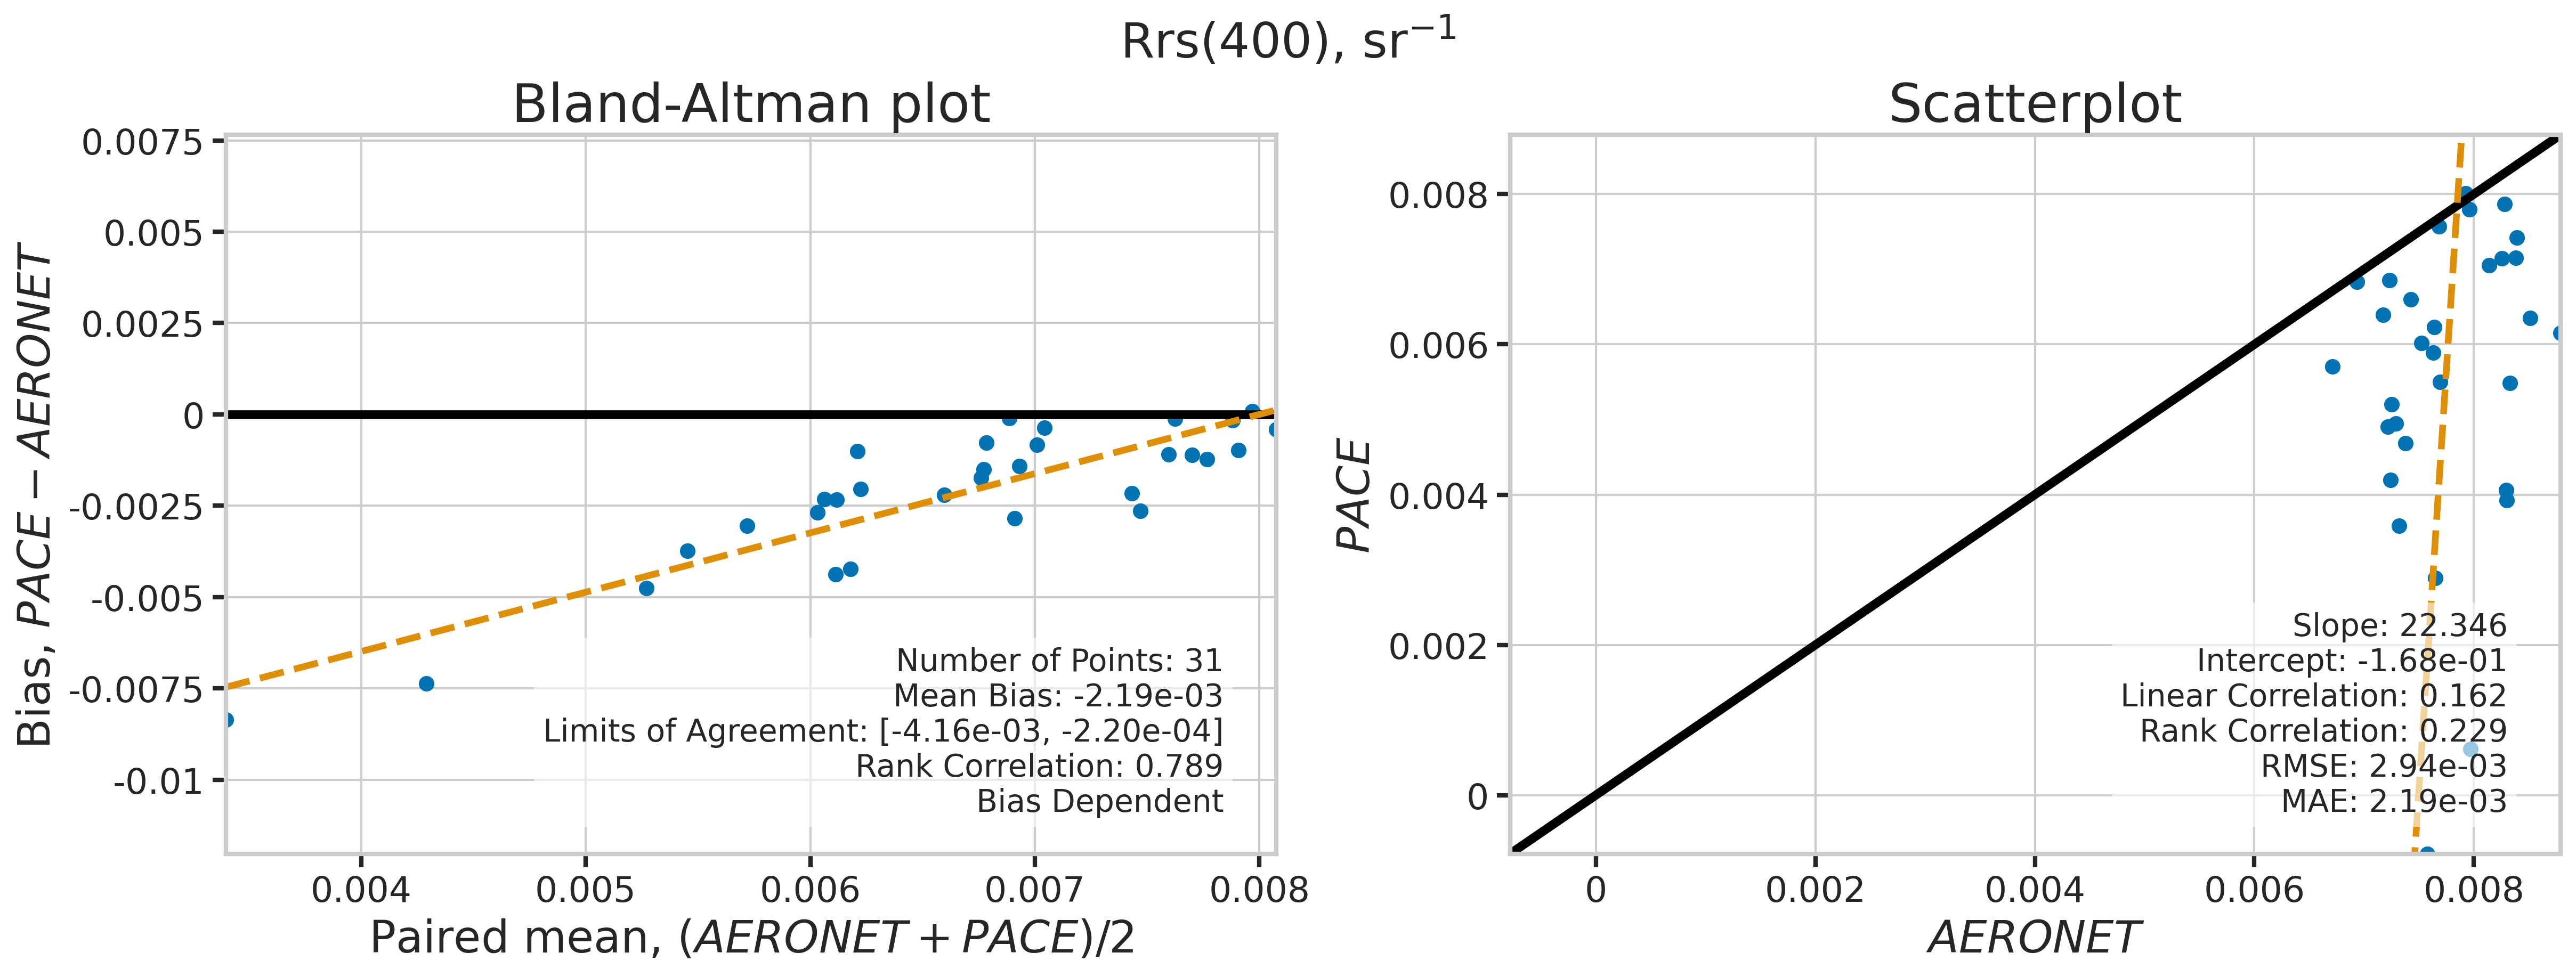

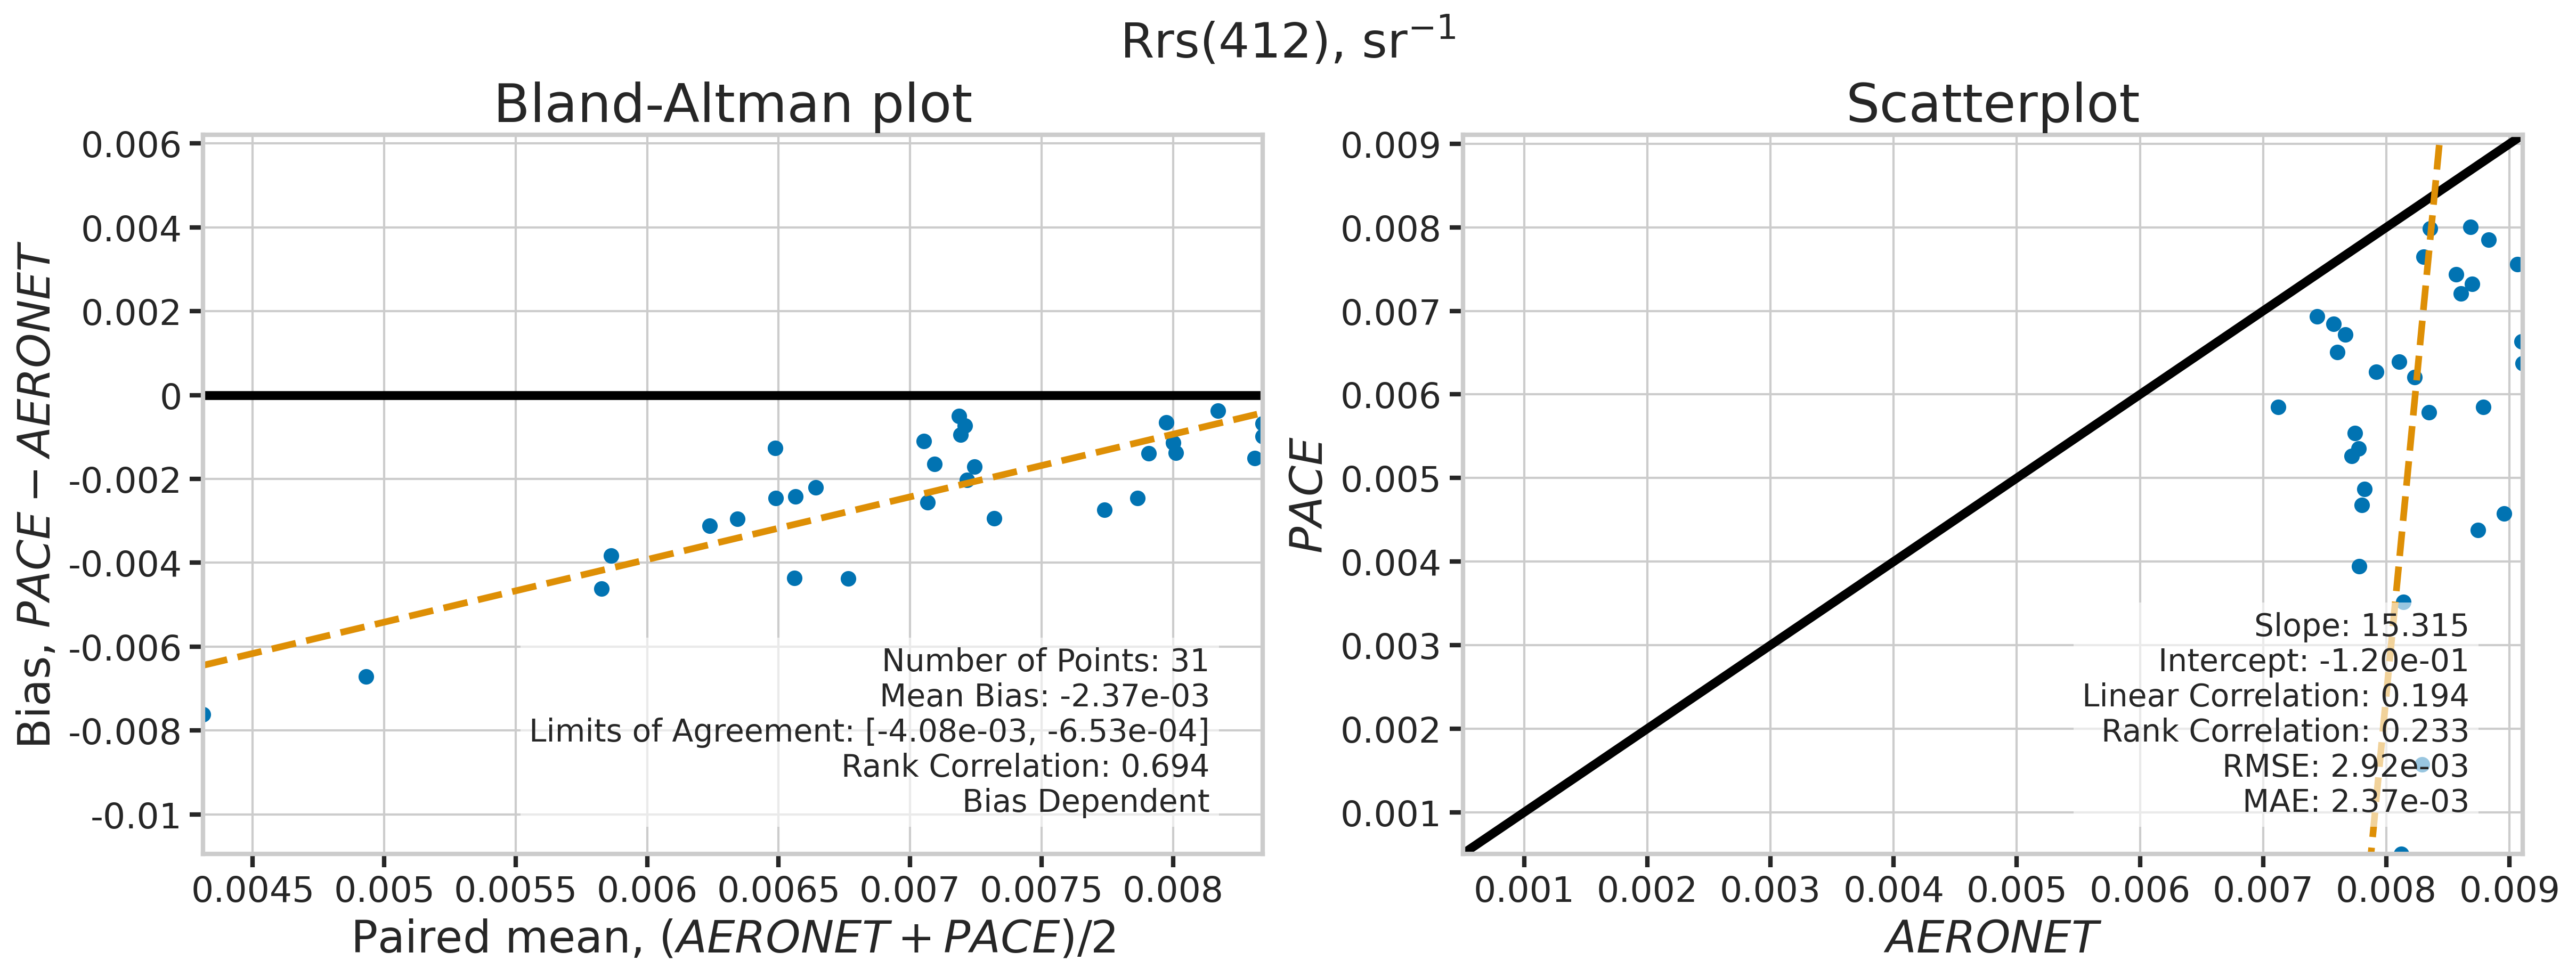

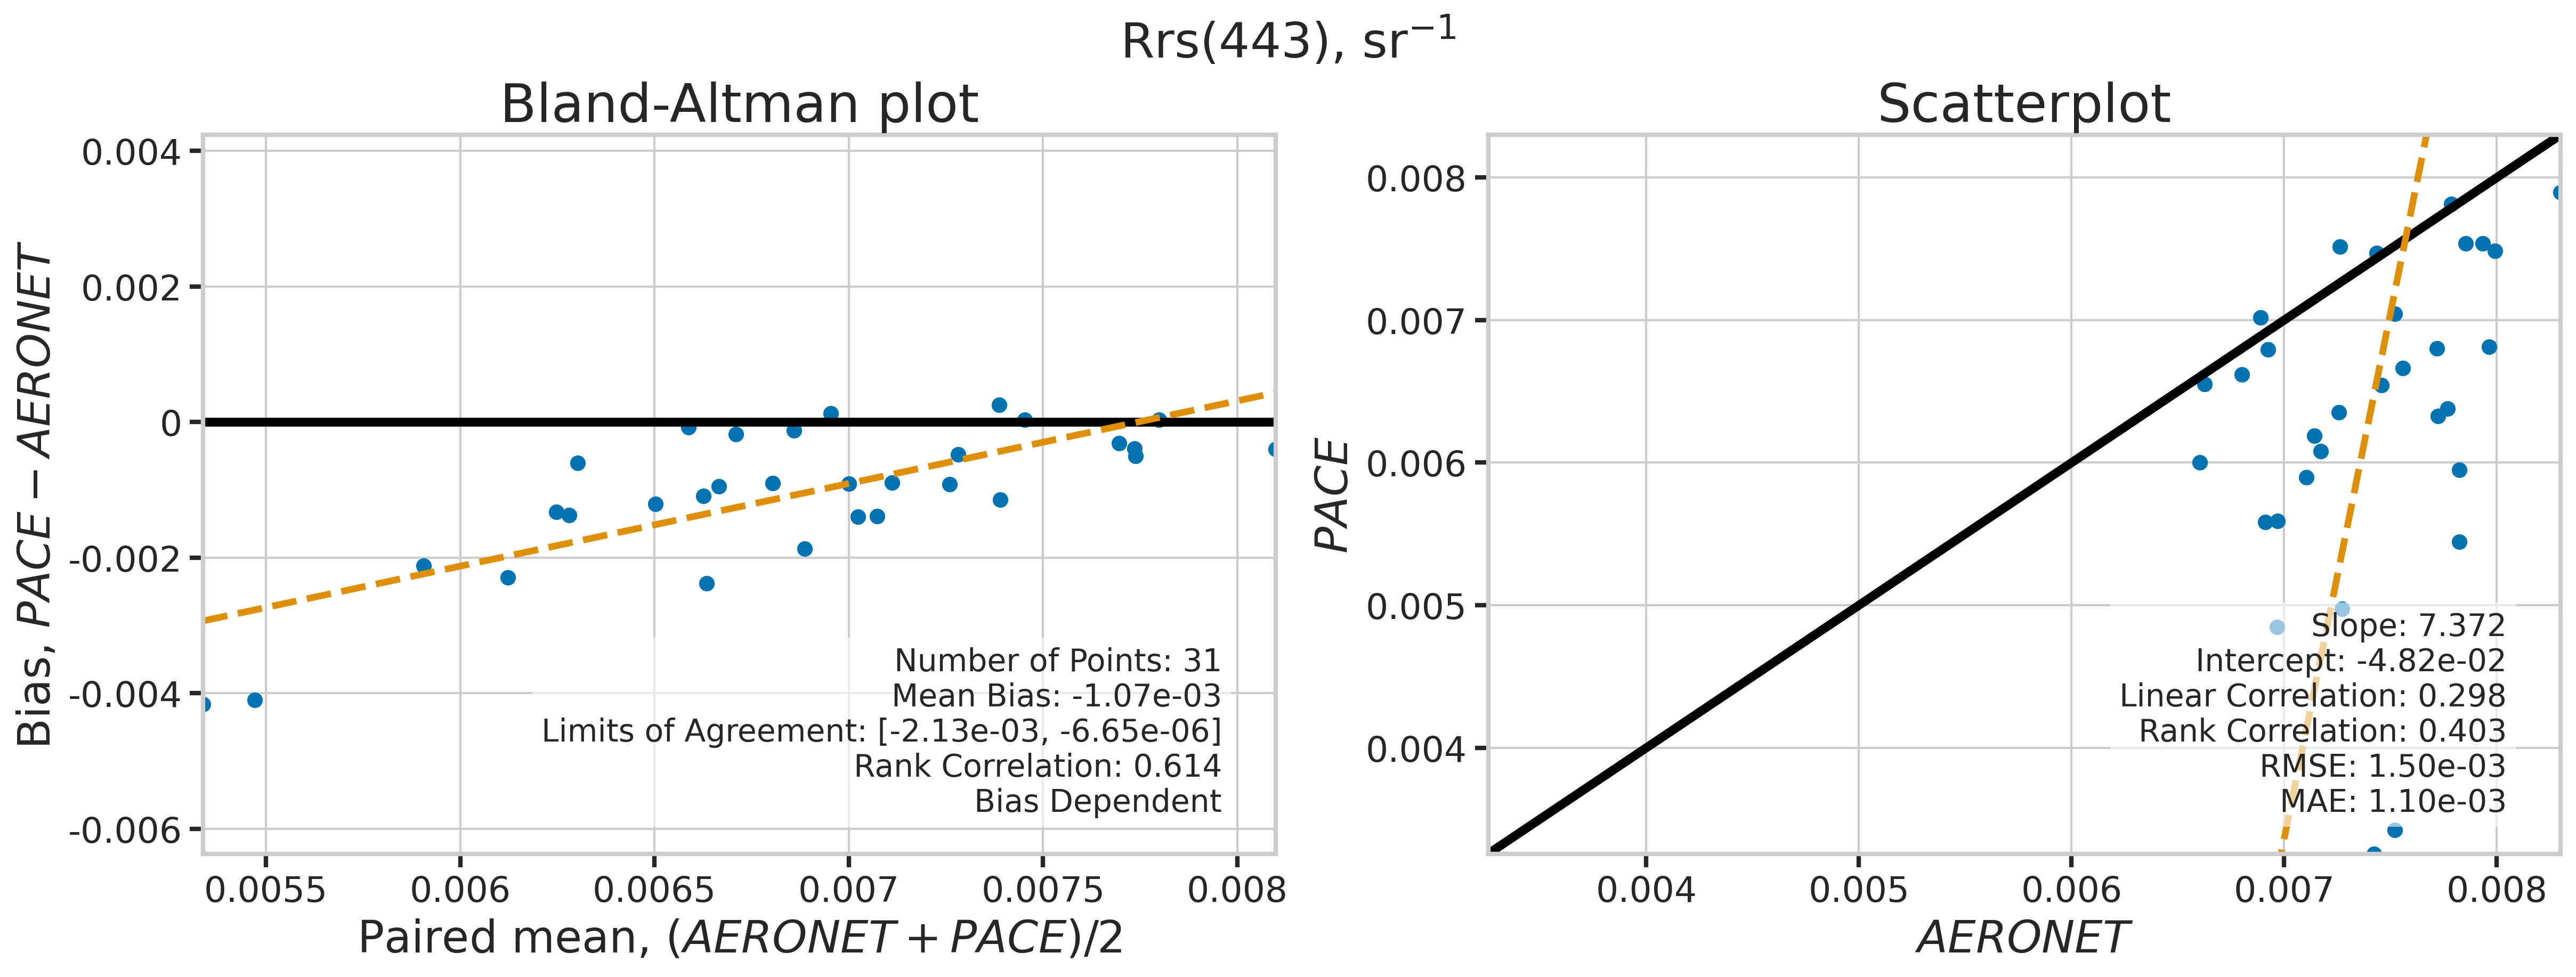

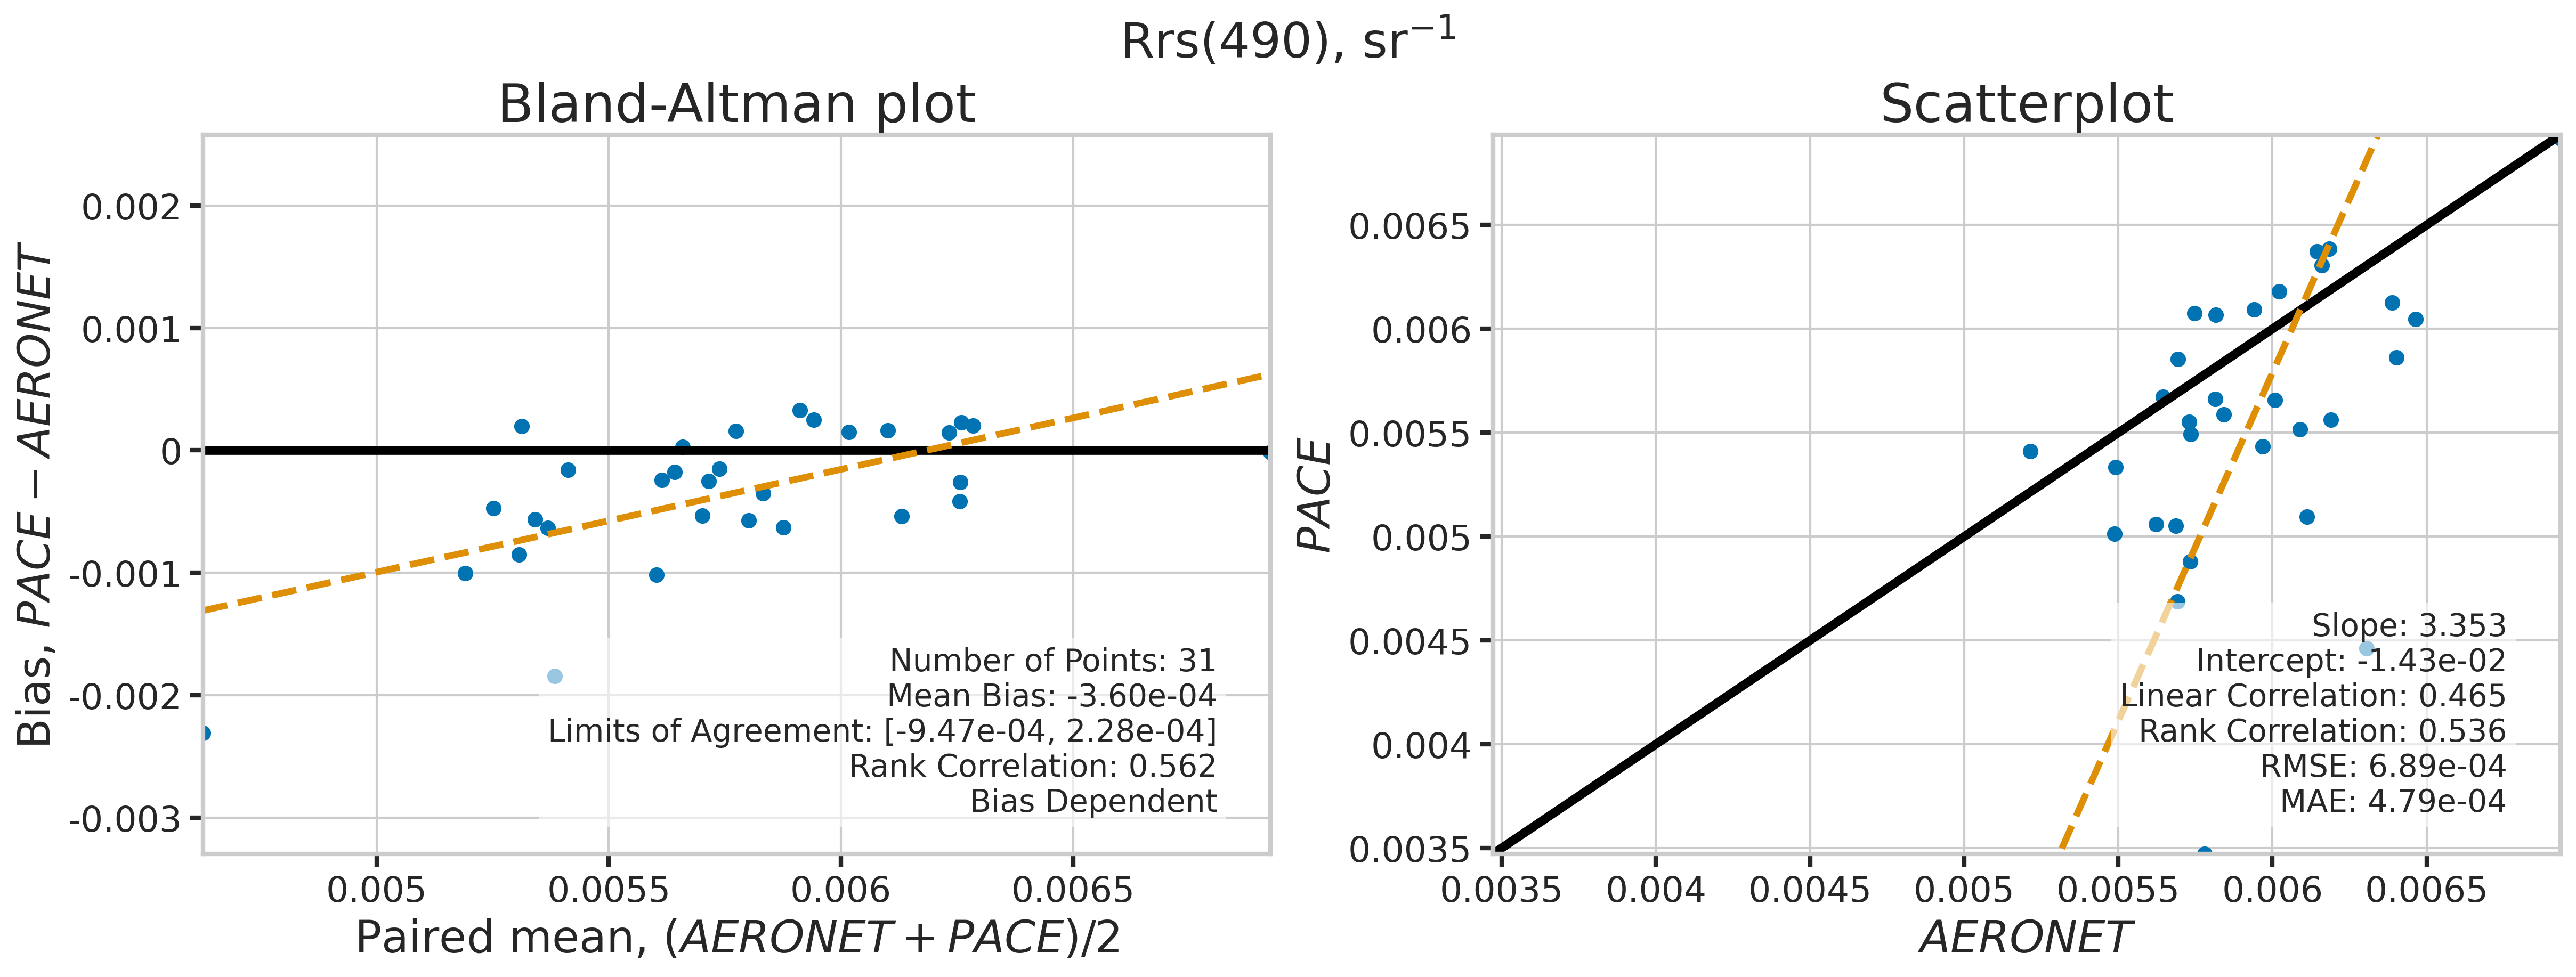

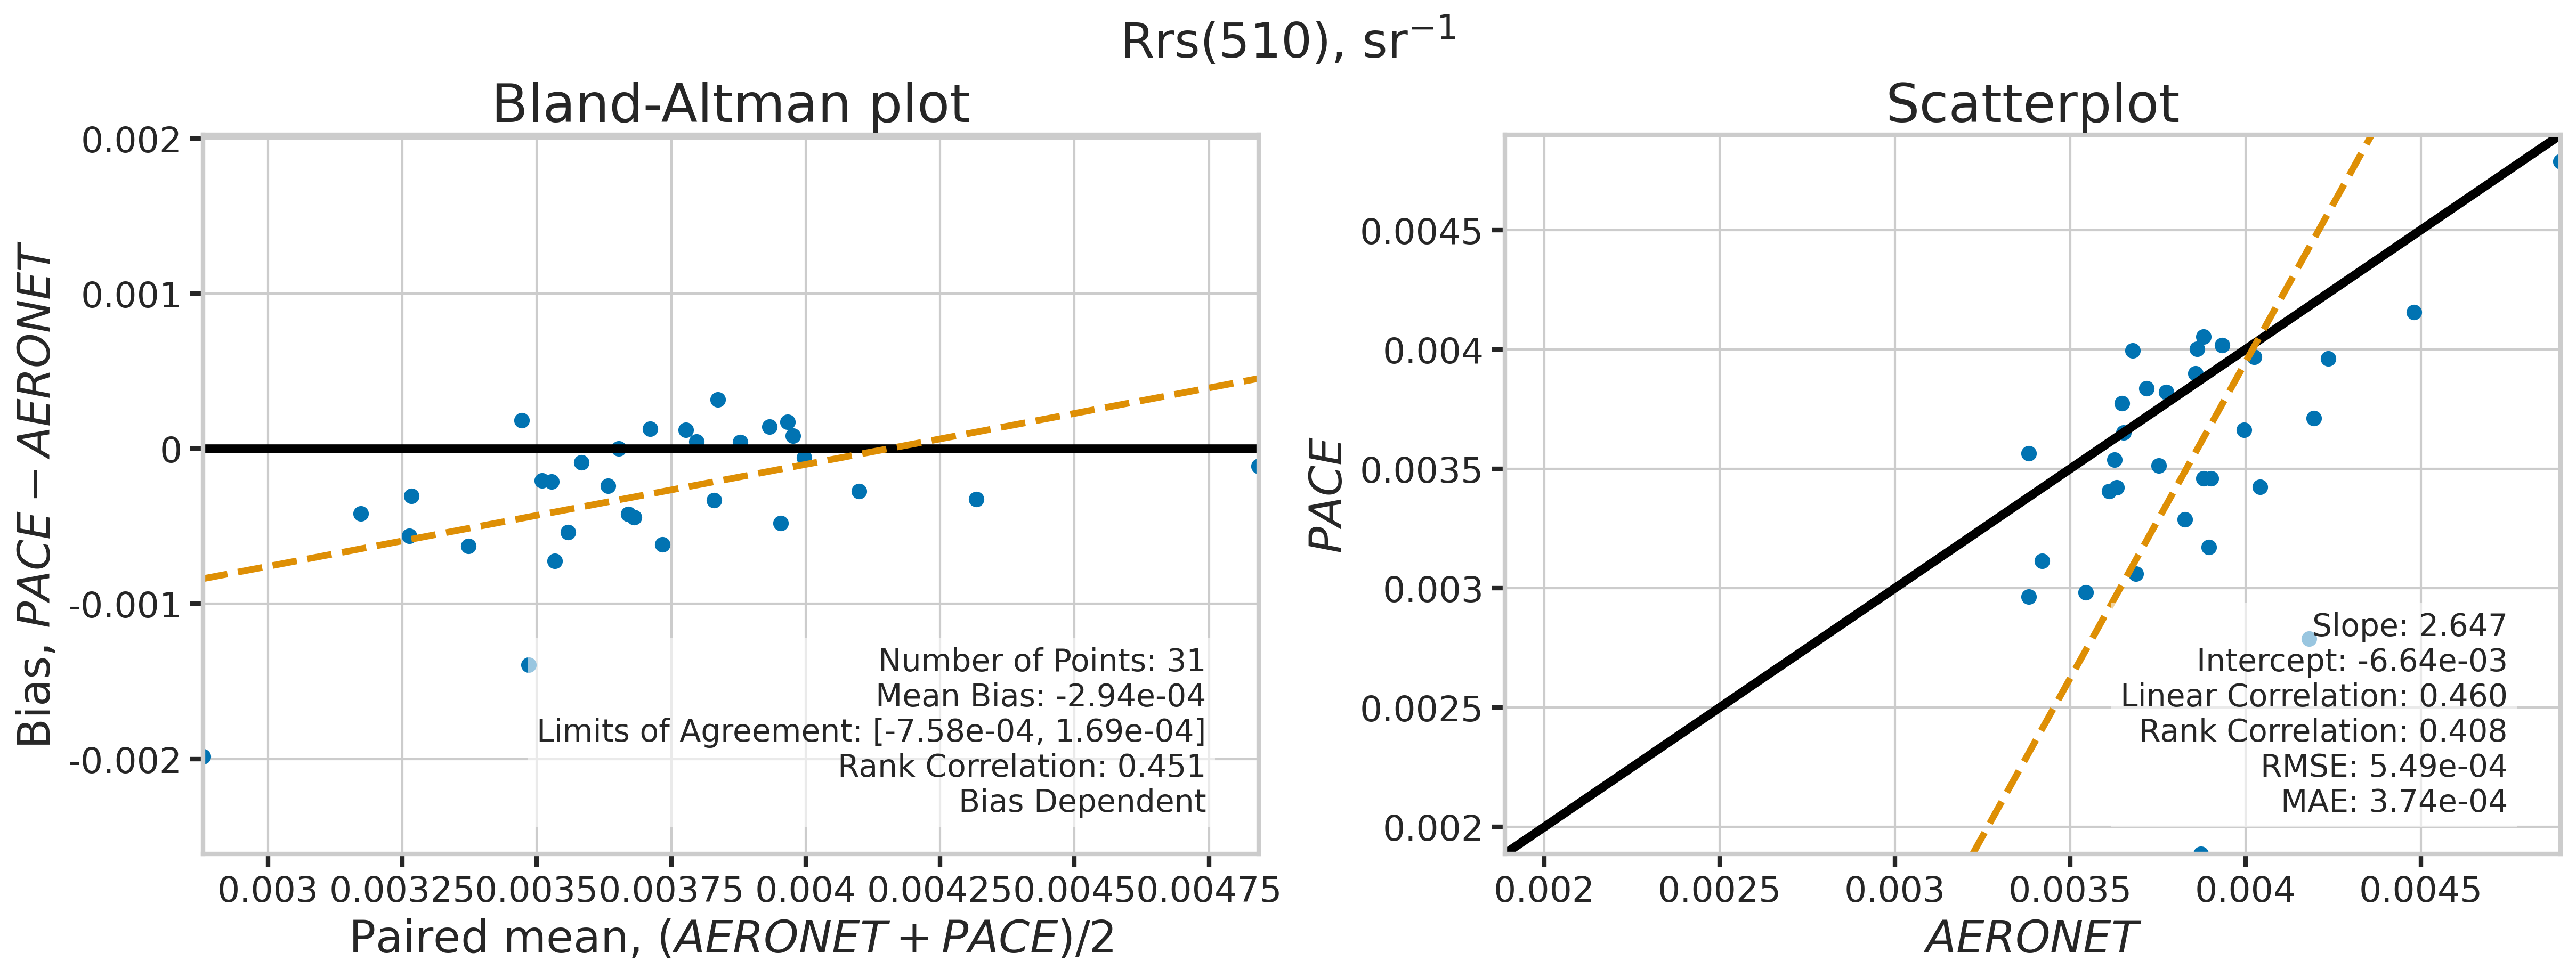

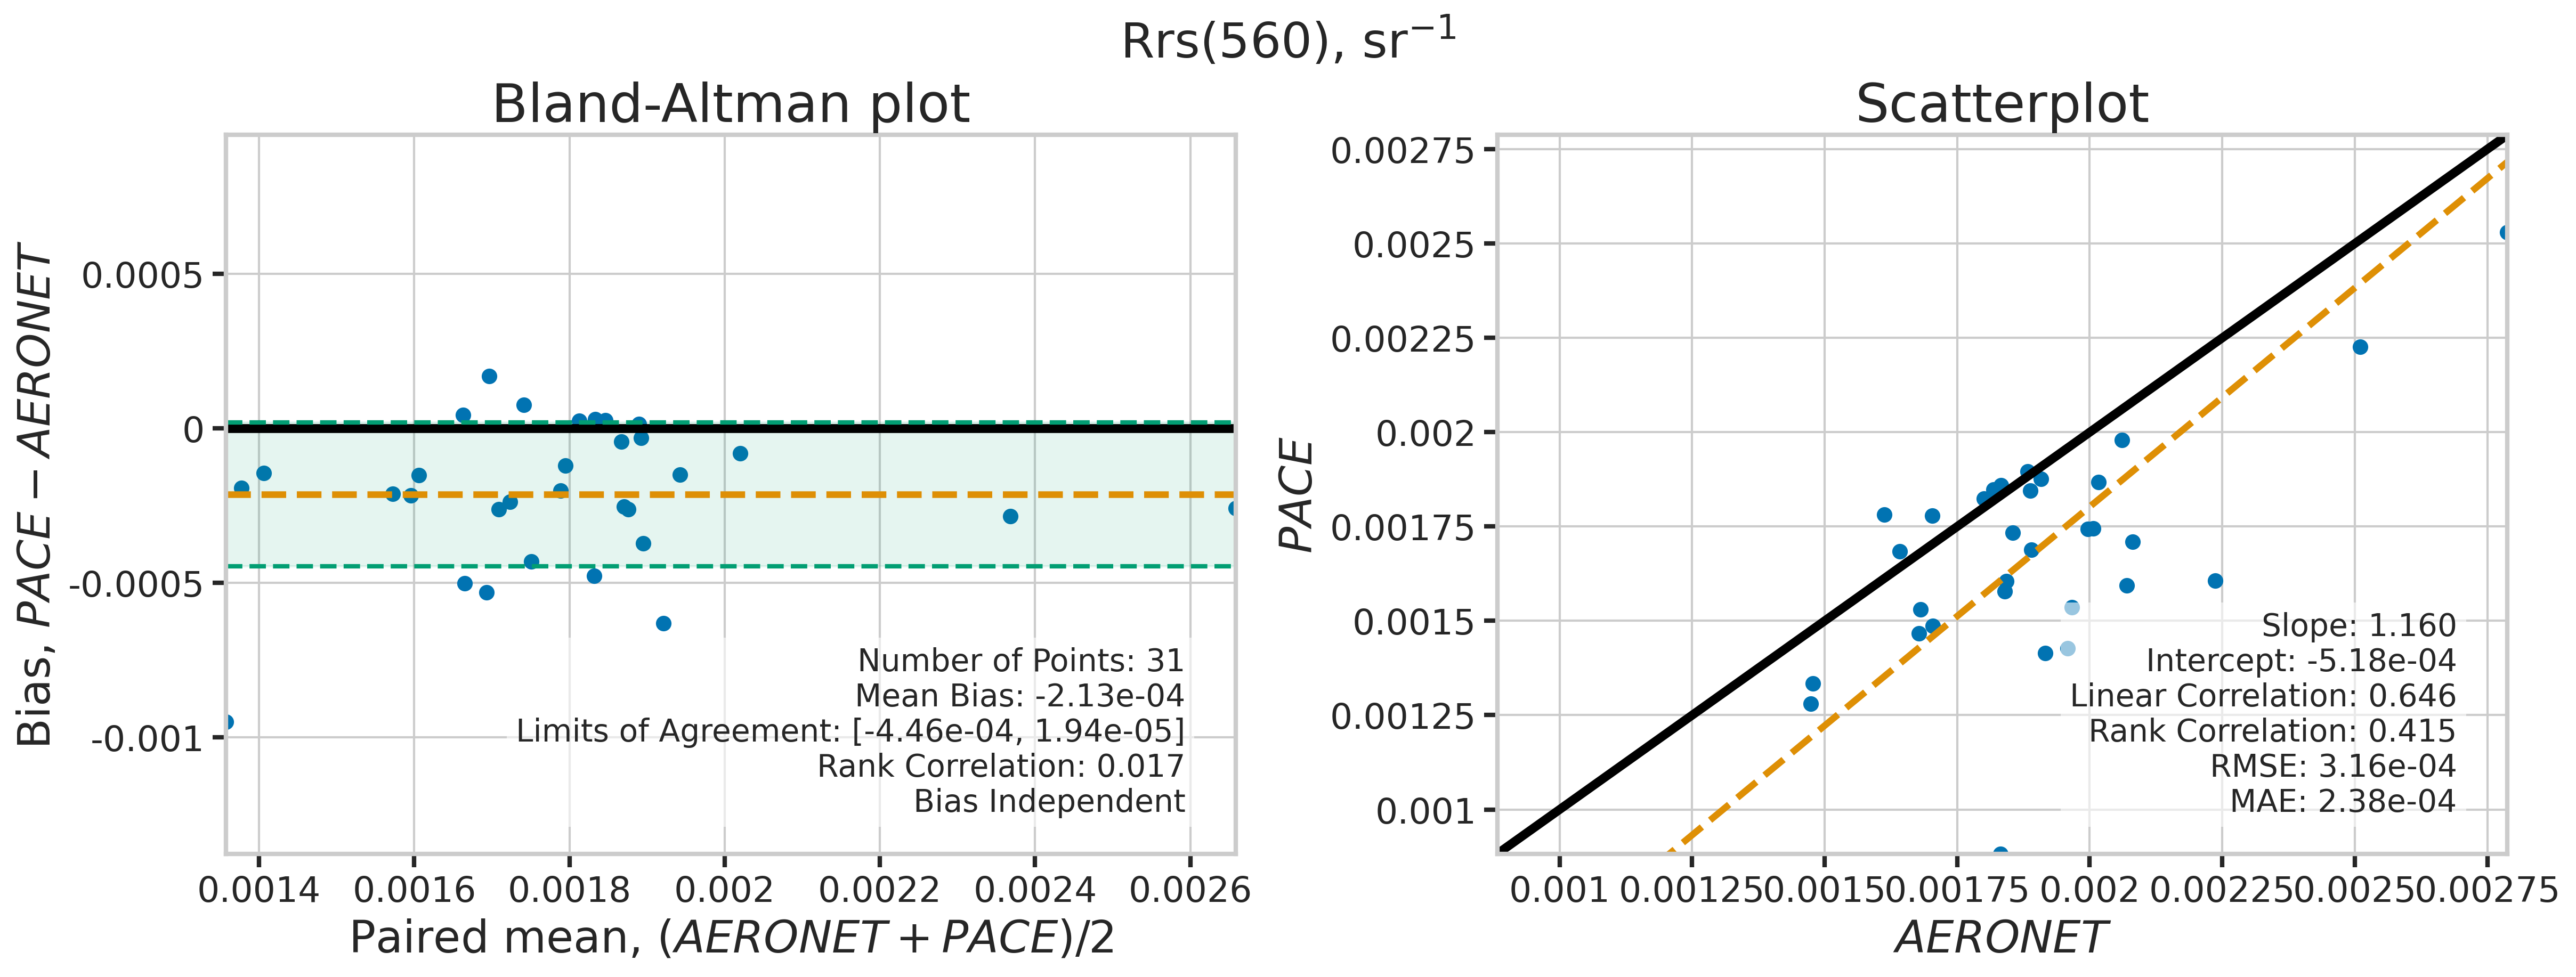

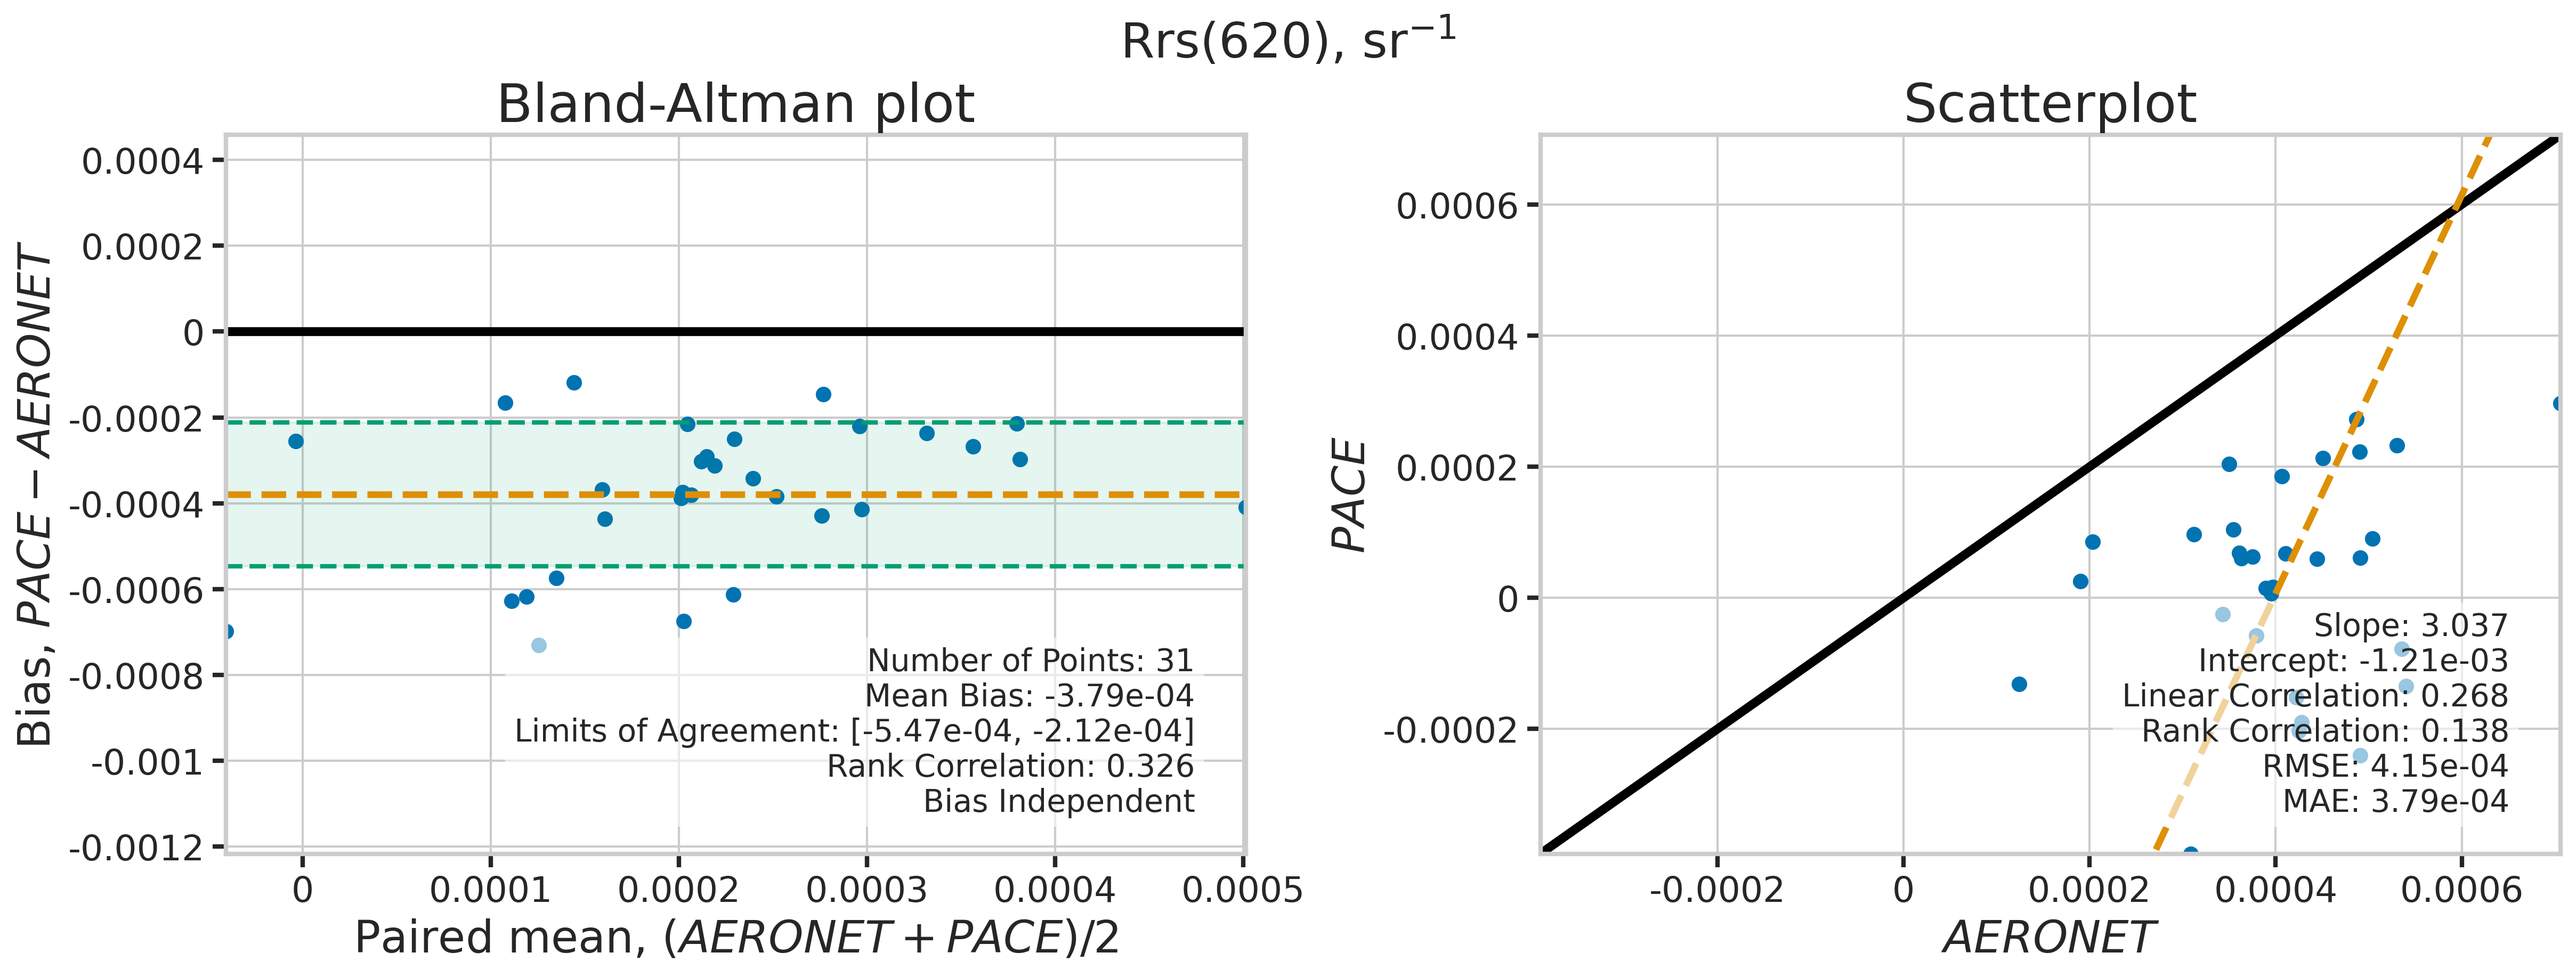

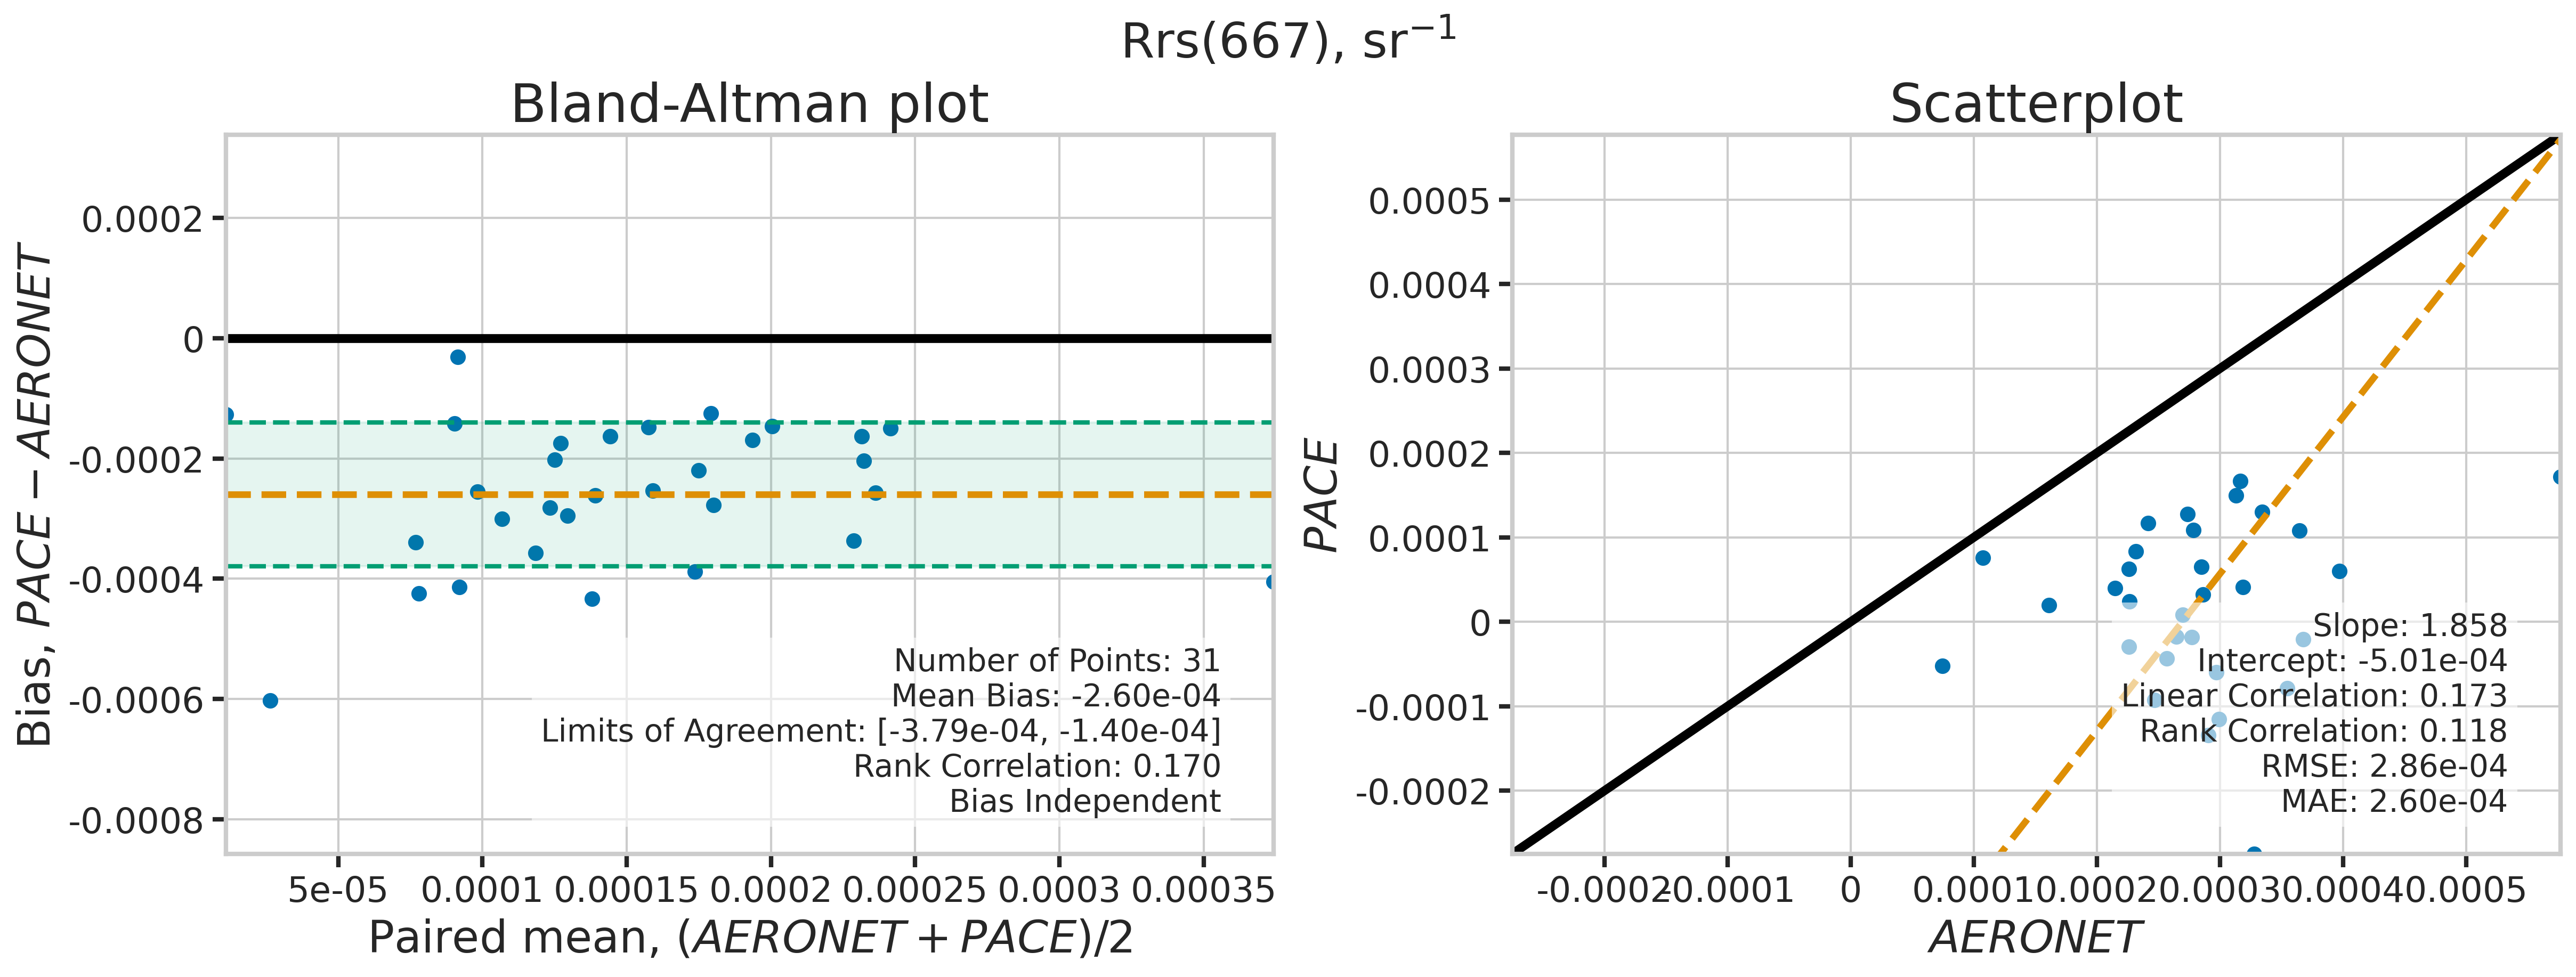

Number_of_Points  Scale_Independence  Mean_Bias  \
wavelength                                                    
400                       31               False  -0.002188   
412                       31               False  -0.002368   
443                       31               False  -0.001067   
490                       31               False  -0.000360   
510                       31               False  -0.000294   
560                       31                True  -0.000213   
620                       31                True  -0.000379   
667                       31                True  -0.000260   

            Limits_of_Agreement_low  Limits_of_Agreement_high  Linear_Slope  \
wavelength                                                                    
400                     -999.000000               -999.000000     22.346014   
412                     -999.000000               -999.000000     15.315123   
443                     -999.000000               -999.000000      7.372392   
490                     -999.000000               -999.000000      3.352709   
510                     -999.000000               -999.000000      2.647192   
560                       -0.000446                  0.000019      1.160110   
620                       -0.000547                 -0.000212      3.036933   
667                       -0.000379                 -0.000140      1.857914   

            Linear_Intercept  Linear_Correlation  Rank_Correlation      RMSE  \
wavelength                                                                     
400                -0.167513            0.162067          0.229032  0.002943   
412                -0.120106            0.193836          0.233065  0.002924   
443                -0.048241            0.298131          0.403226  0.001505   
490                -0.014327            0.465080          0.535887  0.000689   
510                -0.006642            0.459783          0.408065  0.000549   
560                -0.000518            0.645870          0.414919  0.000316   
620                -0.001208            0.268457          0.138306  0.000415   
667                -0.000501            0.172730          0.118145  0.000286   

                 MAE  
wavelength            
400         0.002193  
412         0.002368  
443         0.001096  
490         0.000479  
510         0.000374  
560         0.000238  
620         0.000379  
667         0.000260

In [8]:
MATCH_WAVES = np.array([400, 412, 443, 490, 510, 560, 620, 667])

# Loop through matchup wavelengths
stats_list = []
for idx, match_wave in enumerate(MATCH_WAVES):
    # Find matching OCI columns
    idx_sat = np.where(np.abs(waves_sat - match_wave) <= 5)[0]
    match_sat = np.nanmean(rrs_sat[:, idx_sat], axis=1)

    # Find matching AOC columns
    idx_aoc = np.where(np.abs(waves_aoc - match_wave) <= 5)[0]
    match_aoc = np.nanmean(rrs_aoc[:, idx_aoc], axis=1)

    valid_indices = np.isfinite(match_sat) & np.isfinite(match_aoc)
    if np.sum(valid_indices) > 5:
        fig_label = f"Rrs({match_wave}), sr" + r"$\mathregular{^{-1}}$"
        dict_stats = plot_BAvsScat(match_aoc[valid_indices],
                                   match_sat[valid_indices],
                                   label=fig_label,
                                   saveplot=None,
                                   x_label="AERONET", y_label="PACE",
                                   is_type2=True)
        dict_stats["wavelength"] = match_wave
        stats_list.append(dict_stats)

# Organize stats DataFrame
df_stats = pd.DataFrame(stats_list)
df_stats.set_index('wavelength', inplace=True)
df_stats = df_stats.fillna(-999)
df_stats